# 0. Imports

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1500)
pd.set_option('display.max_colwidth', 150)  # Aumentar a largura da coluna

import warnings
warnings.filterwarnings("ignore")

In [2]:
import lightgbm as lgb
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import optuna
from collections import Counter
import math
import logging

# 1. Functions

## AED

In [91]:
def function_plot_statistics(df, column_name, category, palette='Set2'):

    # Tamanho da figura:
    plt.figure(figsize=(14, 2.5)) 

    # Boxplot sem outliers
    plt.subplot(1, 2, 1) 
    sns.boxplot(palette=palette, x=category, y=column_name, data=df, showfliers=False)
    plt.title(f'Boxplot - {column_name.upper()}')

    # Histograma sem outliers
    plt.subplot(1, 2, 2) 
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_hist_sem_outliers = df[(df[column_name] >= lower_bound) & (df[column_name] <= upper_bound)].copy()

    sns.histplot(data=df_hist_sem_outliers, x=column_name, kde=True, stat='density', hue=category, palette=palette, multiple='dodge', shrink=.8, legend=True, bins='auto')
    plt.title(f'Histograma - {column_name.upper()}')
    plt.tight_layout()
    plt.show()  
 
    # Estatísticas
    display(df.groupby(category)[column_name].describe().round(2).reset_index())

    quantiles = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    display(df.groupby(category)[column].quantile(quantiles).unstack().round(2))

## Multiplos Modelos

In [4]:
class PipelineMultiplosModelos:

    def __init__(self, X, y, seed=42):
        self.X = X
        self.y = y
        self.models = {}  # Modelos treinados
        self.f1_scores = {}  # Métricas de cada modelo
        self.best_params = {}  # Hiperparâmetros otimizados
        self.seed = seed
                    
    def split_treino_teste(self, test_size=0.3, random_state=None):
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=test_size, random_state=random_state)

        qt_dados_treino = self.X_train.shape[0]
        qt_dados_teste = self.X_test.shape[0]

        print(f'\n>> Etapa de split de dados:')
        print(f'> Dados de treino: {qt_dados_treino}')
        print(f'> Dados de teste: {qt_dados_teste}')
        print(f'> Taxa de dados de treino: {qt_dados_treino/(qt_dados_treino+qt_dados_teste)}')

    def busca_hiperparametros(self):

        # Lista de modelos para otimização
        model_param_grid = {
            'AdaBoostClassifier': (AdaBoostClassifier(random_state=self.seed), param_AdaBoostClassifier),
            'XGBClassifier': (XGBClassifier(random_state=self.seed), param_XGBClassifier),
            'LGBMClassifier': (LGBMClassifier(random_state=self.seed), param_LGBMClassifier),
            'LogisticRegression': (LogisticRegression(random_state=self.seed), param_LogisticRegression),
            'KNeighborsClassifier': (KNeighborsClassifier(), param_KNeighborsClassifier),
            'DecisionTreeClassifier': (DecisionTreeClassifier(random_state=self.seed), param_DecisionTreeClassifier),
            'RandomForestClassifier': (RandomForestClassifier(random_state=self.seed), param_RandomForestClassifier),
            # 'SVC': (SVC(random_state=self.seed), param_SVC),
            # 'GradientBoostingClassifier': (GradientBoostingClassifier(random_state=self.seed), param_GradientBoostingClassifier),
            # 'GaussianNB': (GaussianNB(), param_GaussianNB),
            # 'MLPClassifier': (MLPClassifier(random_state=self.seed), param_MLPClassifier),
        }

        # Busca de hiperparâmetros para cada modelo
        print(f"\n>> Melhores hiperparâmetros:")

        for model_name, (model, param_distributions) in model_param_grid.items():
            hyperparams_search = RandomizedSearchCV(
                model,
                param_distributions=param_distributions,
                n_iter=10,
                cv=KFold(n_splits=5, shuffle=True, random_state=self.seed),
                random_state=self.seed,
                n_jobs=-1
            )

            # Treina o RandomizedSearchCV com o conjunto de treino
            hyperparams_search.fit(self.X_train, self.y_train)

            # Armazena os melhores hiperparâmetros
            self.best_params[model_name] = hyperparams_search.best_params_
            print(f"\n> {model_name}: {self.best_params[model_name]}")

    def treino_teste_modelos(self):
        
        # Usando os melhores hiperparâmetros encontrados
        self.models['AdaBoostClassifier'] = AdaBoostClassifier(**self.best_params['AdaBoostClassifier'])
        self.models['XGBClassifier'] = XGBClassifier(**self.best_params['XGBClassifier'])
        self.models['LGBMClassifier'] = LGBMClassifier(**self.best_params['LGBMClassifier'], verbose=-1, force_col_wise=True)
        self.models['LogisticRegression'] = LogisticRegression(**self.best_params['LogisticRegression'])
        self.models['KNeighborsClassifier'] = KNeighborsClassifier(**self.best_params['KNeighborsClassifier'])
        self.models['DecisionTreeClassifier'] = DecisionTreeClassifier(**self.best_params['DecisionTreeClassifier'])
        self.models['RandomForestClassifier'] = RandomForestClassifier(**self.best_params['RandomForestClassifier'])
        # self.models['SVC'] = SVC(**self.best_params['SVC'])
        # self.models['GradientBoostingClassifier'] = GradientBoostingClassifier(**self.best_params['GradientBoostingClassifier'])
        # self.models['GaussianNB'] = GaussianNB(**self.best_params['GaussianNB'])
        # self.models['MLPClassifier'] = MLPClassifier(**self.best_params['MLPClassifier'], early_stopping=True)

        print(f"\n>> F1 de cada modelo:")
        
        # Treina cada modelo
        for model_name, model in self.models.items():
            np.random.seed(self.seed)

            # Treina o modelo
            model.fit(self.X_train, self.y_train)

            # Previsões
            y_pred = model.predict(self.X_test)

            # Métricas de performance
            F1 = f1_score(self.y_test, y_pred)
            print(f'> F1 do {model_name}: {F1}')

            # Salva métrica no dicionário
            self.f1_scores[model_name] = F1

    def metricas_ordenadas(self, palette='Set2', figsize=(12, 3)):
        
        # Ordena f1_scores em ordem decrescente
        self.sorted_metrics = {k: i for k, i in sorted(self.f1_scores.items(), key=lambda item: item[1], reverse=True)}

        # Plota f1_scores
        plt.figure(figsize=figsize)
        ax = sns.barplot(y=list(self.sorted_metrics.keys()), x=list(self.sorted_metrics.values()), palette=palette, orient='h')
        plt.ylabel('Model')
        plt.title('F1 de cada modelo')

        # Configura eixo do gráfico
        for p, value in zip(ax.patches, list(self.sorted_metrics.values())):
            ax.annotate(f"{value:.3f}", (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center', xytext=(5, 0), textcoords='offset points', fontsize=10)
        plt.grid(alpha=0.25)
        plt.show()

    def matriz_confusao_melhor_modelo(self, figsize=(4, 4), cmap='Blues', fontsize=8):
        
        # Obter o melhor modelo
        _, best_model, _ = self.selecionar_melhor_modelo()

        # Previsões
        self.y_pred = best_model.predict(self.X_test)

        # Matriz de confusão
        cm = confusion_matrix(self.y_test, self.y_pred)

        # Plot da matriz de confusão
        plt.figure(figsize=figsize)
        sns.heatmap(cm, annot=True, fmt='g', cmap=cmap, annot_kws={"size": fontsize}, cbar=False)
        plt.title('Matriz de confusão - Melhor modelo')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.grid(alpha=0)
        plt.show()

    def selecionar_melhor_modelo(self):
        
        # Encontrar o modelo com maior F1
        best_model_name = max(self.f1_scores, key=self.f1_scores.get)
        best_model = self.models[best_model_name]

        return best_model_name, best_model, self.f1_scores[best_model_name]

## Optuna

In [5]:
def optuna_objective_function(trial, X_train,  X_test, y_train, y_test):
    
    params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "bagging_freq": 1,
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.2, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 5),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-4, 1.0, log=True), # reg_alpha = L1
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-4, 1.0, log=True), # reg_lambda = L2
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    return f1

## Testes de hiperparametros

In [6]:
def AdaBoost_hyperparams_test(lista_teste, nome_hiperparametro, X_train, X_test, y_train, y_test, palette):

    results = {f'{nome_hiperparametro}': [], 'recall': [], 'precision': [], 'f1': [], 'roc_auc': []}
    
    for i in lista_teste:
        
        params = {nome_hiperparametro: i}

        model = AdaBoostClassifier(**params)
        model.fit(X_train, y_train)
        # print(model)
        
        # Fazer previsões
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calcular métricas
        recall = round(recall_score(y_test, y_pred),2)
        precision = round(precision_score(y_test, y_pred),2)
        f1 = round(f1_score(y_test, y_pred),2)
        roc_auc = round(roc_auc_score(y_test, y_pred_proba),2)
        
        # Armazenar resultados
        results[f'{nome_hiperparametro}'].append(i)
        results['recall'].append(recall)
        results['precision'].append(precision)
        results['f1'].append(f1)
        results['roc_auc'].append(roc_auc)
    
    # Plotar os resultados
    paleta = plt.get_cmap(palette) 

    print(f'>> Hiperparâmetro: {nome_hiperparametro}')
    print(f'>> Modelo: AdaBoost')
    
    plt.figure(figsize=(14, 3))
    plt.plot(results[f'{nome_hiperparametro}'], results['recall'], label='Recall', marker='o', markersize=5, color=paleta(0))
    plt.plot(results[f'{nome_hiperparametro}'], results['precision'], label='Precision', marker='o', markersize=5, color=paleta(0.5))
    plt.plot(results[f'{nome_hiperparametro}'], results['f1'], label='F1', marker='o', markersize=5, color=paleta(0.8))
    plt.xlabel(f'{nome_hiperparametro}')
    plt.ylabel('Score')
    plt.title(f'Impacto do {nome_hiperparametro} no Desempenho do Modelo (na etapa de teste)')
    # plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

    df_results = pd.DataFrame(results)
    
    # if table_results:
    #     display(df_results)

    return df_results

In [7]:
def LGBM_hyperparams_test(lista_teste, nome_hiperparametro, X_train, X_test, y_train, y_test, palette):

    results = {f'{nome_hiperparametro}': [], 'recall': [], 'precision': [], 'f1': [], 'roc_auc': []}
    
    for i in lista_teste:
        
        params = {nome_hiperparametro: i}

        model = LGBMClassifier(**params)
        model.fit(X_train, y_train)
        # print(model)
        
        # Fazer previsões
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calcular métricas
        recall = round(recall_score(y_test, y_pred),2)
        precision = round(precision_score(y_test, y_pred),2)
        f1 = round(f1_score(y_test, y_pred),2)
        roc_auc = round(roc_auc_score(y_test, y_pred_proba),2)
        
        # Armazenar resultados
        results[f'{nome_hiperparametro}'].append(i)
        results['recall'].append(recall)
        results['precision'].append(precision)
        results['f1'].append(f1)
        results['roc_auc'].append(roc_auc)
    
    # Plotar os resultados
    paleta = plt.get_cmap(palette) 
    
    print(f'>> Hiperparâmetro: {nome_hiperparametro}')
    print(f'>> Modelo: LGBM')
    
    plt.figure(figsize=(14, 3))
    plt.plot(results[f'{nome_hiperparametro}'], results['recall'], label='Recall', marker='o', markersize=5, color=paleta(0))
    plt.plot(results[f'{nome_hiperparametro}'], results['precision'], label='Precision', marker='o', markersize=5, color=paleta(0.5))
    plt.plot(results[f'{nome_hiperparametro}'], results['f1'], label='F1', marker='o', markersize=5, color=paleta(0.8))
    plt.xlabel(f'{nome_hiperparametro}')
    plt.ylabel('Score')
    plt.title(f'Impacto do {nome_hiperparametro} no Desempenho do Modelo (na etapa de teste)')
    # plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

    df_results = pd.DataFrame(results)
    
    # if table_results:
    #     display(df_results)

    return df_results

In [8]:
def XGBClassifier_hyperparams_test(lista_teste, nome_hiperparametro, X_train, X_test, y_train, y_test, palette):
    
    results = {f'{nome_hiperparametro}': [], 'recall': [], 'precision': [], 'f1': [], 'roc_auc': []}
    
    for i in lista_teste:
        
        params = {nome_hiperparametro: i}

        model = XGBClassifier(**params, 
                              objective="binary:logistic", # logistic regression for binary classification, output probability
                              verbosity=0, 
                              silent=True)
        
        model.fit(X_train, y_train)

        # print(model)
        
        # Fazer previsões
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calcular métricas
        recall = round(recall_score(y_test, y_pred),2)
        precision = round(precision_score(y_test, y_pred),2)
        f1 = round(f1_score(y_test, y_pred),2)
        roc_auc = round(roc_auc_score(y_test, y_pred_proba),2)
        
        # Armazenar resultados
        results[f'{nome_hiperparametro}'].append(i)
        results['recall'].append(recall)
        results['precision'].append(precision)
        results['f1'].append(f1)
        results['roc_auc'].append(roc_auc)
    
    # Plotar os resultados
    paleta = plt.get_cmap(palette) 
    
    print(f'>> Hiperparâmetro: {nome_hiperparametro}')
    print(f'>> Modelo: XGBoost')    
    
    plt.figure(figsize=(14, 3))
    plt.plot(results[f'{nome_hiperparametro}'], results['recall'], label='Recall', marker='o', markersize=5, color=paleta(0))
    plt.plot(results[f'{nome_hiperparametro}'], results['precision'], label='Precision', marker='o', markersize=5, color=paleta(0.5))
    plt.plot(results[f'{nome_hiperparametro}'], results['f1'], label='F1', marker='o', markersize=5, color=paleta(0.8))
    plt.xlabel(f'{nome_hiperparametro}')
    plt.ylabel('Score')
    plt.title(f'Impacto do {nome_hiperparametro} no Desempenho do Modelo (na etapa de teste)')
    # plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

    df_results = pd.DataFrame(results)
    
    # if table_results:
    #     display(df_results)

    return df_results

In [9]:
def RandomForestClassifier_hyperparams_test(lista_teste, nome_hiperparametro, X_train, X_test, y_train, y_test, palette):
    
    results = {f'{nome_hiperparametro}': [], 'recall': [], 'precision': [], 'f1': [], 'roc_auc': []}
    
    for i in lista_teste:
        
        params = {nome_hiperparametro: i}

        model = RandomForestClassifier(**param)
        
        model.fit(X_train, y_train)

        # print(model)
        
        # Fazer previsões
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calcular métricas
        recall = round(recall_score(y_test, y_pred),2)
        precision = round(precision_score(y_test, y_pred),2)
        f1 = round(f1_score(y_test, y_pred),2)
        roc_auc = round(roc_auc_score(y_test, y_pred_proba),2)
        
        # Armazenar resultados
        results[f'{nome_hiperparametro}'].append(i)
        results['recall'].append(recall)
        results['precision'].append(precision)
        results['f1'].append(f1)
        results['roc_auc'].append(roc_auc)
    
    # Plotar os resultados
    paleta = plt.get_cmap(palette) 
    
    plt.figure(figsize=(14, 3))
    plt.plot(results[f'{nome_hiperparametro}'], results['recall'], label='Recall', marker='o', markersize=5, color=paleta(0))
    plt.plot(results[f'{nome_hiperparametro}'], results['precision'], label='Precision', marker='o', markersize=5, color=paleta(0.5))
    plt.plot(results[f'{nome_hiperparametro}'], results['f1'], label='F1', marker='o', markersize=5, color=paleta(0.8))
    plt.xlabel(f'{nome_hiperparametro}')
    plt.ylabel('Score')
    plt.title(f'Impacto do {nome_hiperparametro} no Desempenho do Modelo (na etapa de teste)')
    # plt.xscale('log')
    plt.legend()
    plt.grid(True)
    plt.show()

    df_results = pd.DataFrame(results)
    
    # if table_results:
    #     display(df_results)

    return df_results

# 2. Dados

## 2.1 - Crédito

### Importa dados de crédito

In [10]:
df_credit = pd.read_csv('credit_risk_dataset.csv')

In [11]:
df_credit.head(2)

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2

### Trata dados de crédito

In [12]:
print(f'>> Colunas nulas: {df_credit.columns[df_credit.isnull().any()].tolist()}')

>> Colunas nulas: ['person_emp_length', 'loan_int_rate']


In [13]:
for i in df_credit.columns[df_credit.isnull().any()].tolist(): 

    perc_null_info = df_credit[df_credit[i].isnull()].shape[0]*100/df_credit.shape[0]
    
    print(f'\n>> NULL INFO in {i} column:')
    
    print(f'> Percentage: {round(perc_null_info,2)}%')
    print(f'> Count: {df_credit[df_credit[i].isnull()].shape[0]}')
    
    print(f'> Non-null info distribution in {i} column:')
    display(df_credit[~df_credit[i].isnull()].groupby('loan_status')[i].describe().reset_index().round(2))


>> NULL INFO in person_emp_length column:
> Percentage: 2.75%
> Count: 895
> Non-null info distribution in person_emp_length column:


loan_status    count  mean   std  min  25%  50%  75%    max
0            0  24860.0  4.97  4.13  0.0  2.0  4.0  7.0  123.0
1            1   6826.0  4.14  4.13  0.0  1.0  3.0  6.0  123.0


>> NULL INFO in loan_int_rate column:
> Percentage: 9.56%
> Count: 3116
> Non-null info distribution in loan_int_rate column:


loan_status    count   mean   std   min    25%    50%    75%    max
0            0  23001.0  10.44  2.98  5.42   7.68  10.59  12.69  22.06
1            1   6464.0  13.06  3.29  5.42  10.74  13.49  15.58  23.22

In [14]:
# Preencher nulos pela média
for i in df_credit.columns[df_credit.isnull().any()].tolist(): 

    print(f'> Média dos valores de {i}: {round(df_credit[i].mean(),2)}')

    # Preencher pelo número inteiro próximo à média
    df_credit[i].fillna(int(round(df_credit[i].mean(),0)), inplace=True)

> Média dos valores de person_emp_length: 4.79
> Média dos valores de loan_int_rate: 11.01


In [15]:
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           32581 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               32581 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


## 2.2 - Smoke Detection

### Importa dados de smoke

In [16]:
df_smoke_original = pd.read_csv('smoke_detection_iot.csv')

# Dropa colunas desnecessárias
df_smoke_original = df_smoke_original.drop(['Unnamed: 0','UTC'], axis=1)

# Ajusta colunas
df_smoke_original.columns = df_smoke_original.columns.str.replace(r'[^a-zA-Z0-9_]', '', regex=True)

In [17]:
df_smoke_original.head(2)

TemperatureC  Humidity  TVOCppb  eCO2ppm  RawH2  RawEthanol  PressurehPa  \
0        20.000     57.36        0      400  12306       18520      939.735   
1        20.015     56.67        0      400  12345       18651      939.744   

   PM10  PM25  NC05  NC10  NC25  CNT  FireAlarm  
0   0.0   0.0   0.0   0.0   0.0    0          0  
1   0.0   0.0   0.0   0.0   0.0    1          0

In [18]:
df_smoke_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62630 entries, 0 to 62629
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TemperatureC  62630 non-null  float64
 1   Humidity      62630 non-null  float64
 2   TVOCppb       62630 non-null  int64  
 3   eCO2ppm       62630 non-null  int64  
 4   RawH2         62630 non-null  int64  
 5   RawEthanol    62630 non-null  int64  
 6   PressurehPa   62630 non-null  float64
 7   PM10          62630 non-null  float64
 8   PM25          62630 non-null  float64
 9   NC05          62630 non-null  float64
 10  NC10          62630 non-null  float64
 11  NC25          62630 non-null  float64
 12  CNT           62630 non-null  int64  
 13  FireAlarm     62630 non-null  int64  
dtypes: float64(8), int64(6)
memory usage: 6.7 MB


### Trata dados de smoke

In [19]:
# Passo 1: Selecionar as instâncias da classe 1
df_class1_smoke_sample = df_smoke_original[df_smoke_original['FireAlarm'] == 1].copy()

# Passo 2: Selecionar 40% das instâncias da classe 1
df_class1_smoke_random_sample = df_class1_smoke_sample.sample(frac=0.4, random_state=42)

# Passo 3: Alterar a classe de 1 para 0
df_class1_smoke_random_sample['FireAlarm'] = 0

# Passo 4: Remover as instâncias selecionadas da classe 1 do DataFrame original
df_smoke_without_random_sample = df_smoke_original.drop(df_class1_smoke_random_sample.index)

# Passo 5: Adicionar as novas instâncias (agora com classe 0) de volta ao DataFrame
df_smoke = pd.concat([df_smoke_without_random_sample, df_class1_smoke_random_sample], ignore_index=True)

# Verificar as classes no DataFrame atualizado
print(df_smoke.groupby('FireAlarm').FireAlarm.count())

FireAlarm
0    35776
1    26854
Name: FireAlarm, dtype: int64


# 3. Distribuição dos dados

## Crédito

In [20]:
classes_distribution_credit = df_credit.groupby('loan_status').size()*100/len(df_credit)

df_classes_distribution_credit = pd.merge(df_credit.groupby('loan_status').size().reset_index(name='count'), 
                                   classes_distribution_credit.reset_index(name='percentage').round(2), 
                                   on=['loan_status'], 
                                   how='left')

df_classes_distribution_credit

loan_status  count  percentage
0            0  25473       78.18
1            1   7108       21.82

In [21]:
features_list_credit = [col for col in df_credit.columns.to_list() if col not in ['loan_status']]

categorical_features_list_credit = df_credit.select_dtypes(include=['object']).columns.tolist()

numeric_features_list_credit = [col for col in features_list_credit if col not in categorical_features_list_credit]

print(f'\n>> CREDIT DATASET:')

print(f'\n> Features: {features_list_credit}')
print(f'\n> Categorical Features: {categorical_features_list_credit}')
print(f'\n> Numeric Features: {numeric_features_list_credit}')


>> CREDIT DATASET:

> Features: ['person_age', 'person_income', 'person_home_ownership', 'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file', 'cb_person_cred_hist_length']

> Categorical Features: ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

> Numeric Features: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']


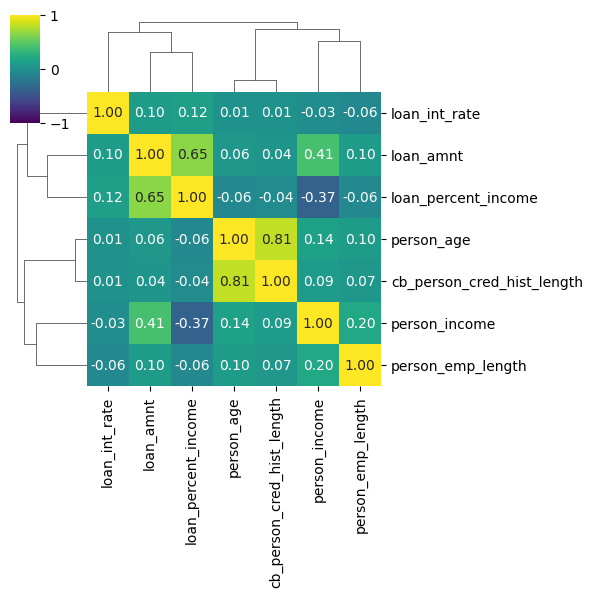

In [97]:
sns.clustermap(df_credit[numeric_features_list_credit].corr(method='spearman').round(2), figsize=(6,6), annot=True, cmap='viridis', fmt=".2f", vmin=-1, vmax=1)
plt.show()


>> Feature: person_age


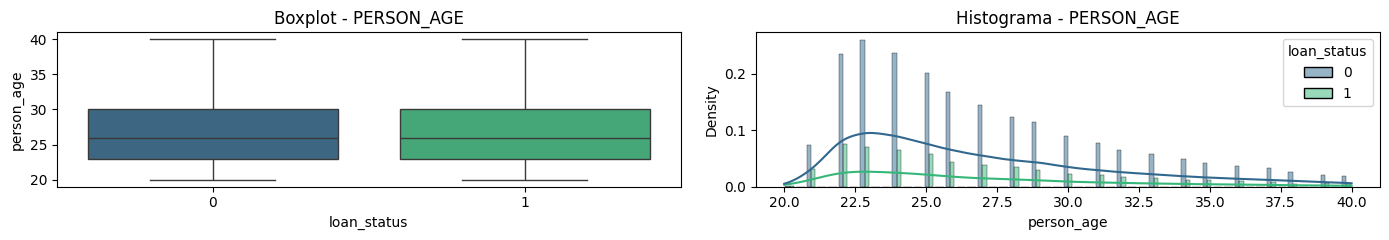

loan_status    count   mean   std   min   25%   50%   75%    max
0            0  25473.0  27.81  6.37  20.0  23.0  26.0  30.0  144.0
1            1   7108.0  27.47  6.26  20.0  23.0  26.0  30.0   70.0

0.00  0.05  0.10  0.15  0.20  0.25  0.30  0.35  0.40  0.45  0.50  \
loan_status                                                                     
0            20.0  22.0  22.0  23.0  23.0  23.0  24.0  24.0  25.0  25.0  26.0   
1            20.0  21.0  22.0  22.0  23.0  23.0  24.0  24.0  24.0  25.0  26.0   

             0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95   1.00  
loan_status                                                               
0            27.0  27.0  28.0  29.0  30.0  32.0  33.0  36.0  40.0  144.0  
1            26.0  27.0  28.0  29.0  30.0  31.0  33.0  36.0  40.0   70.0




>> Feature: person_income


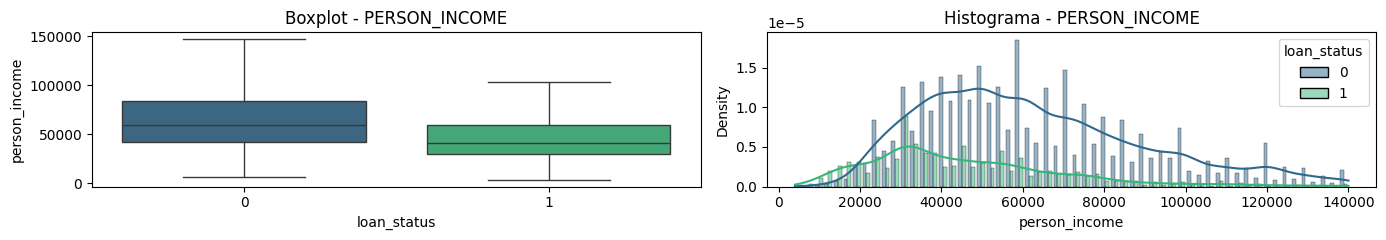

loan_status    count      mean       std     min      25%      50%  \
0            0  25473.0  70804.36  66568.80  7000.0  42000.0  60000.0   
1            1   7108.0  49125.65  36907.38  4000.0  30000.0  41498.0   

        75%        max  
0  84000.00  6000000.0  
1  59497.75   703800.0

0.00     0.05     0.10     0.15     0.20     0.25     0.30  \
loan_status                                                                 
0            7000.0  26000.0  31000.0  35345.6  39693.4  42000.0  45600.0   
1            4000.0  15000.0  19000.0  23800.0  27000.0  30000.0  31000.0   

                0.35     0.40     0.45     0.50     0.55     0.60     0.65  \
loan_status                                                                  
0            50000.0  52000.0  55696.8  60000.0  63142.8  68000.0  72000.0   
1            33000.0  35000.0  38000.0  41498.0  44004.0  48000.0  52000.0   

                0.70      0.75     0.80      0.85      0.90      0.95  \
loan_status                                                             
0            78000.0  84000.00  91610.4  100000.0  119000.0  144000.0   
1            55000.0  59497.75  65026.8   73000.0   80487.0  105790.0   

                  1.00  
loan_status             
0            6000000.0  
1             703800.0




>> Feature: person_emp_length


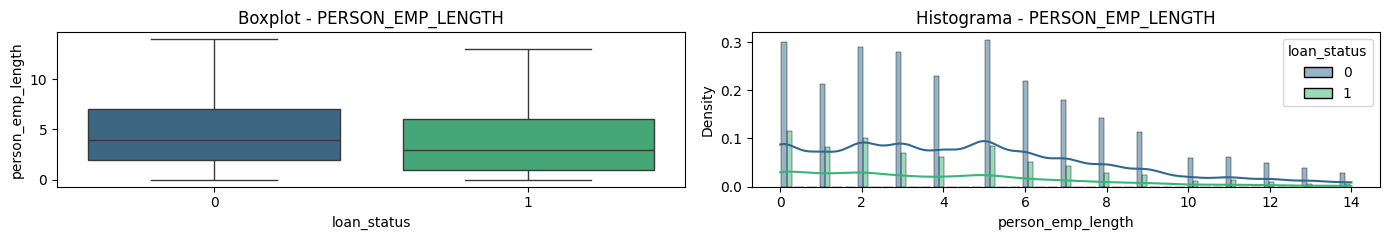

loan_status    count  mean   std  min  25%  50%  75%    max
0            0  25473.0  4.97  4.08  0.0  2.0  4.0  7.0  123.0
1            1   7108.0  4.17  4.05  0.0  1.0  3.0  6.0  123.0

0.00  0.05  0.10  0.15  0.20  0.25  0.30  0.35  0.40  0.45  0.50  \
loan_status                                                                     
0             0.0   0.0   0.0   1.0   2.0   2.0   2.0   3.0   3.0   4.0   4.0   
1             0.0   0.0   0.0   0.0   1.0   1.0   2.0   2.0   2.0   3.0   3.0   

             0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95   1.00  
loan_status                                                               
0             5.0   5.0   6.0   6.0   7.0   8.0   9.0  10.0  13.0  123.0  
1             4.0   5.0   5.0   5.0   6.0   7.0   8.0   9.0  11.0  123.0




>> Feature: loan_amnt


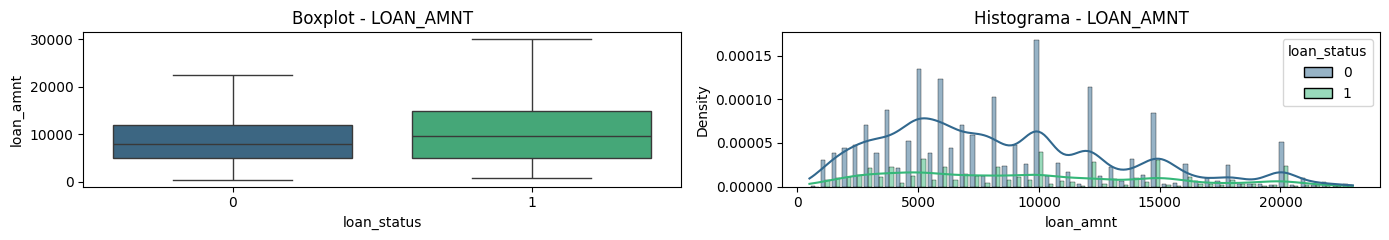

loan_status    count      mean      std    min     25%     50%      75%  \
0            0  25473.0   9237.46  6026.38  500.0  5000.0  8000.0  12000.0   
1            1   7108.0  10850.50  7143.35  900.0  5000.0  9600.0  15000.0   

       max  
0  35000.0  
1  35000.0

0.00    0.05    0.10    0.15    0.20    0.25    0.30    0.35  \
loan_status                                                                  
0            500.0  2000.0  3000.0  3600.0  4300.0  5000.0  5200.0  6000.0   
1            900.0  2100.0  3000.0  3700.0  4500.0  5000.0  6000.0  6700.0   

               0.40    0.45    0.50     0.55     0.60     0.65     0.70  \
loan_status                                                               
0            6425.0  7060.0  8000.0   8500.0  10000.0  10000.0  11000.0   
1            7500.0  8400.0  9600.0  10000.0  11200.0  12000.0  14000.0   

                0.75     0.80     0.85     0.90     0.95     1.00  
loan_status                                                        
0            12000.0  13650.0  15000.0  18000.0  21000.0  35000.0  
1            15000.0  16000.0  19800.0  21000.0  25000.0  35000.0




>> Feature: loan_int_rate


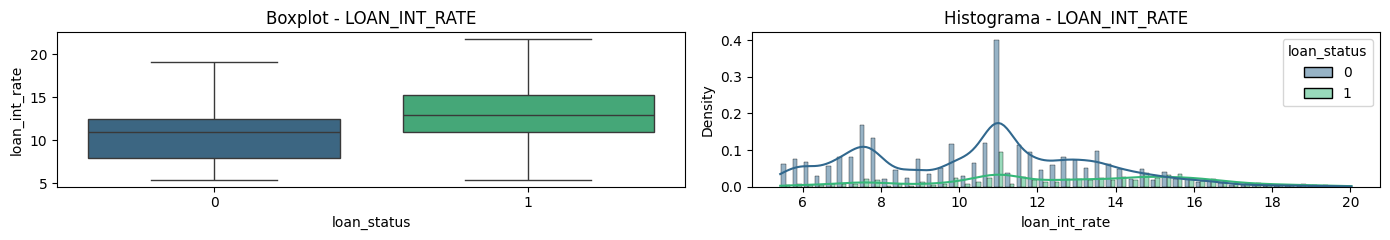

loan_status    count   mean   std   min    25%    50%    75%    max
0            0  25473.0  10.49  2.84  5.42   7.88  10.99  12.42  22.06
1            1   7108.0  12.87  3.20  5.42  10.99  12.99  15.31  23.22

0.00  0.05  0.10  0.15   0.20   0.25   0.30   0.35   0.40   0.45  \
loan_status                                                                     
0            5.42  6.03  6.76  7.29   7.51   7.88   8.49   9.51   9.99  10.59   
1            5.42  7.29  7.90  9.76  10.38  10.99  11.00  11.11  11.71  12.42   

              0.50   0.55   0.60   0.65   0.70   0.75   0.80   0.85   0.90  \
loan_status                                                                  
0            10.99  11.00  11.00  11.48  11.86  12.42  12.99  13.49  14.22   
1            12.99  13.49  14.11  14.59  14.91  15.31  15.65  16.07  16.77   

              0.95   1.00  
loan_status                
0            15.23  22.06  
1            17.74  23.22




>> Feature: loan_percent_income


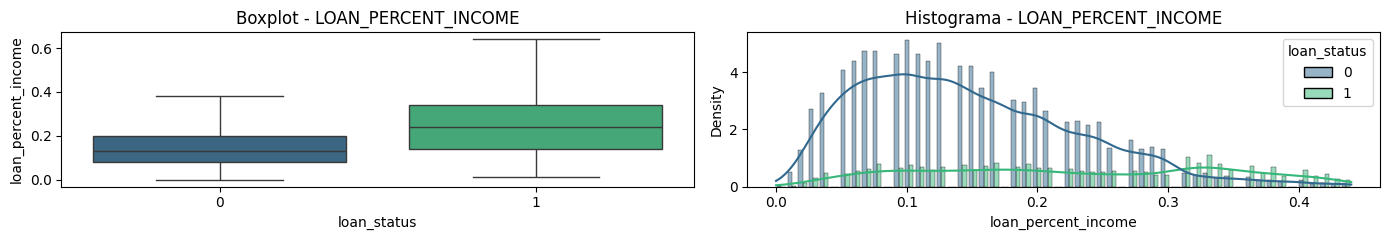

loan_status    count  mean   std   min   25%   50%   75%   max
0            0  25473.0  0.15  0.09  0.00  0.08  0.13  0.20  0.83
1            1   7108.0  0.25  0.13  0.01  0.14  0.24  0.34  0.78

0.00  0.05  0.10  0.15  0.20  0.25  0.30  0.35  0.40  0.45  0.50  \
loan_status                                                                     
0            0.00  0.04  0.05  0.06  0.07  0.08  0.09  0.10  0.11  0.12  0.13   
1            0.01  0.06  0.08  0.10  0.12  0.14  0.16  0.17  0.19  0.21  0.24   

             0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00  
loan_status                                                              
0            0.15  0.16  0.17  0.19  0.20  0.22  0.24  0.27  0.30  0.83  
1            0.26  0.29  0.31  0.33  0.34  0.36  0.39  0.42  0.47  0.78




>> Feature: cb_person_cred_hist_length


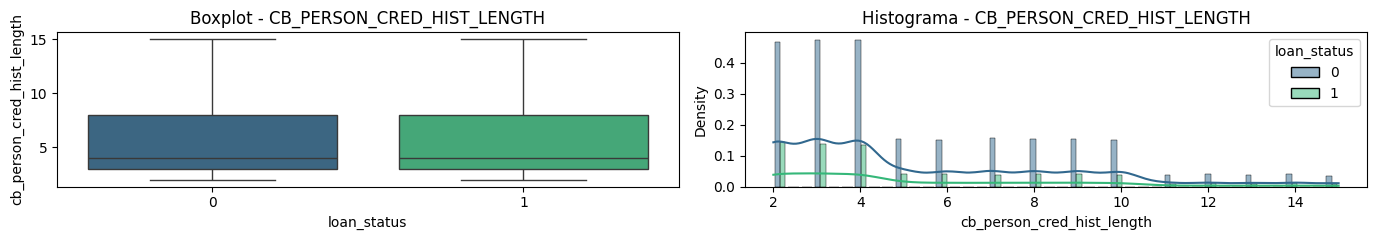

loan_status    count  mean   std  min  25%  50%  75%   max
0            0  25473.0  5.84  4.04  2.0  3.0  4.0  8.0  30.0
1            1   7108.0  5.69  4.10  2.0  3.0  4.0  8.0  30.0

0.00  0.05  0.10  0.15  0.20  0.25  0.30  0.35  0.40  0.45  0.50  \
loan_status                                                                     
0             2.0   2.0   2.0   2.0   3.0   3.0   3.0   3.0   4.0   4.0   4.0   
1             2.0   2.0   2.0   2.0   3.0   3.0   3.0   3.0   4.0   4.0   4.0   

             0.55  0.60  0.65  0.70  0.75  0.80  0.85  0.90  0.95  1.00  
loan_status                                                              
0             5.0   6.0   6.0   7.0   8.0   9.0  10.0  11.0  14.0  30.0  
1             4.0   5.0   6.0   7.0   8.0   9.0  10.0  11.0  14.0  30.0

In [92]:
for column in numeric_features_list_credit:
    
    print("\n>> Feature:", column)
    function_plot_statistics(df_credit, column, category='loan_status', palette='viridis')
    print("\n")

## Smoke Detection

In [24]:
classes_distribution_smoke_original = df_smoke_original.groupby('FireAlarm').size()*100/len(df_smoke)

classes_distribution_smoke_original = pd.merge(df_smoke_original.groupby('FireAlarm').size().reset_index(name='count'), 
                                   classes_distribution_smoke_original.reset_index(name='percentage').round(2), 
                                   on=['FireAlarm'], 
                                   how='left')

classes_distribution_smoke_original

FireAlarm  count  percentage
0          0  17873       28.54
1          1  44757       71.46

In [25]:
classes_distribution_smoke = df_smoke.groupby('FireAlarm').size()*100/len(df_smoke)

df_classes_distribution_smoke = pd.merge(df_smoke.groupby('FireAlarm').size().reset_index(name='count'), 
                                   classes_distribution_smoke.reset_index(name='percentage').round(2), 
                                   on=['FireAlarm'], 
                                   how='left')

df_classes_distribution_smoke

FireAlarm  count  percentage
0          0  35776       57.12
1          1  26854       42.88

In [26]:
features_list_smoke = [col for col in df_smoke.columns.to_list() if col not in ['FireAlarm']]

print('>> Features:  ',features_list_smoke)

>> Features:   ['TemperatureC', 'Humidity', 'TVOCppb', 'eCO2ppm', 'RawH2', 'RawEthanol', 'PressurehPa', 'PM10', 'PM25', 'NC05', 'NC10', 'NC25', 'CNT']


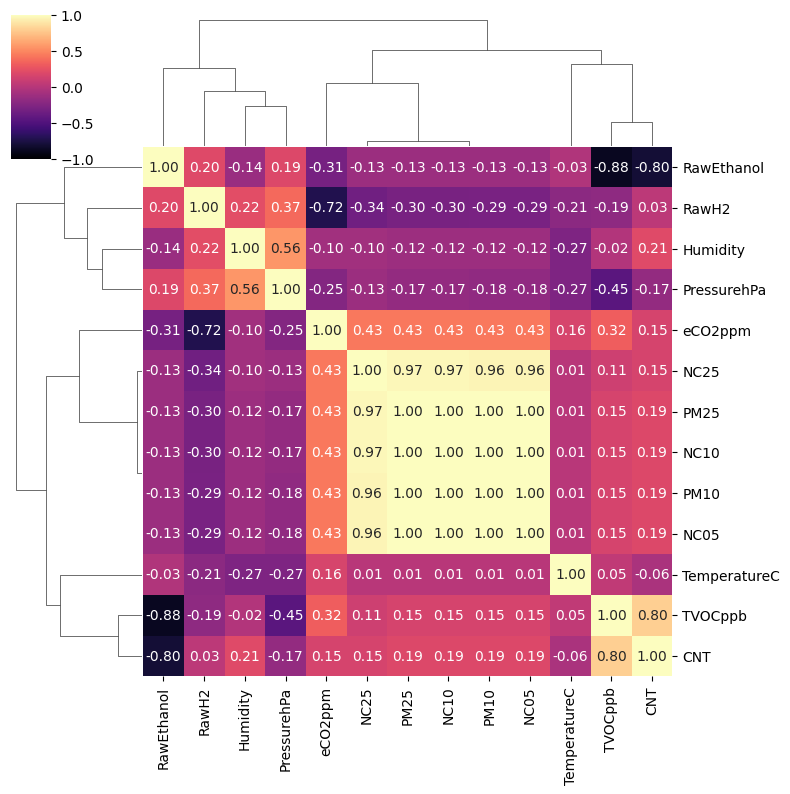

In [27]:
sns.clustermap(df_smoke[features_list_smoke].corr(method='spearman').round(2), figsize=(8, 8), annot=True, cmap='magma', fmt=".2f", vmin=-1, vmax=1)
plt.show()

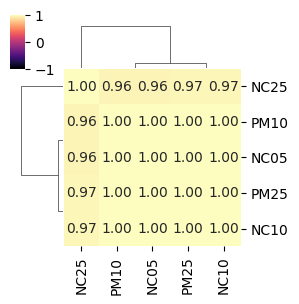

In [94]:
sns.clustermap(df_smoke[['PM10', 'PM25', 'NC10', 'NC25', 'NC05']].corr(method='spearman').round(2), figsize=(3, 3), annot=True, cmap='magma', fmt=".2f", vmin=-1, vmax=1)
plt.show()


>> Feature: TemperatureC


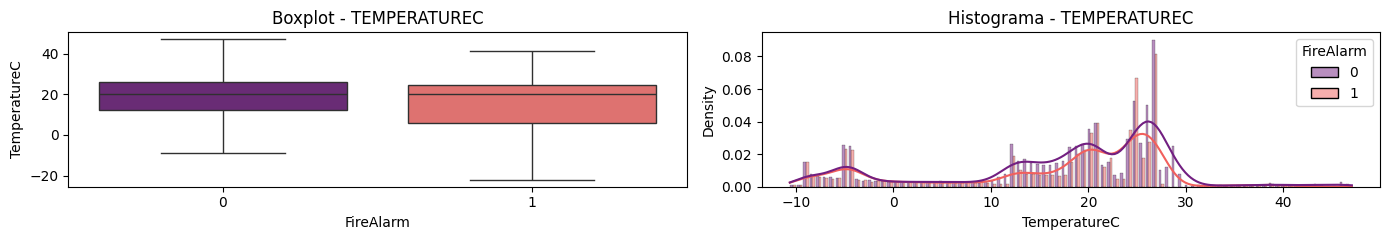

FireAlarm    count   mean    std    min    25%    50%    75%    max
0          0  35776.0  17.04  14.66 -22.01  12.08  20.20  26.09  59.93
1          1  26854.0  14.54  13.82 -22.01   5.73  20.06  24.75  41.41

0.00   0.05  0.10  0.15  0.20   0.25   0.30   0.35   0.40   0.45  \
FireAlarm                                                                      
0         -22.01  -9.18 -5.22 -3.95  5.36  12.08  13.73  15.90  17.95  19.14   
1         -22.01 -11.61 -6.96 -4.73 -2.34   5.73  12.25  14.69  17.86  19.14   

            0.50   0.55   0.60   0.65   0.70   0.75   0.80   0.85   0.90  \
FireAlarm                                                                  
0          20.20  20.85  23.06  24.55  25.19  26.09  26.65  26.98  28.28   
1          20.06  20.71  21.62  24.07  24.51  24.75  25.28  26.39  26.80   

            0.95   1.00  
FireAlarm                
0          36.55  59.93  
1          27.02  41.41




>> Feature: Humidity


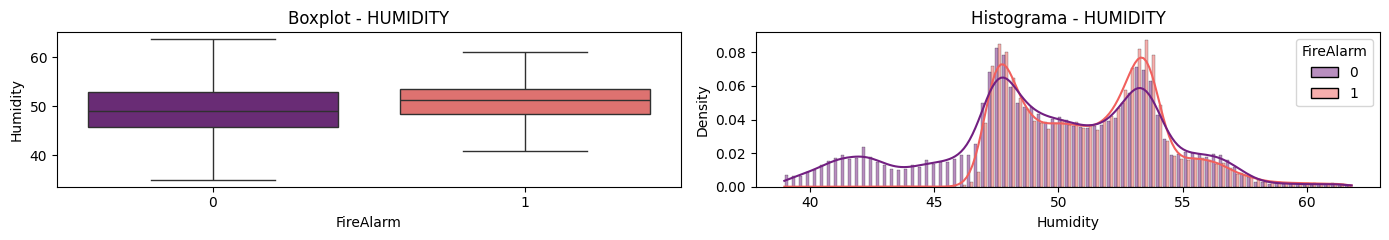

FireAlarm    count   mean    std    min    25%    50%    75%    max
0          0  35776.0  46.87  10.21  10.74  45.75  49.06  52.92  75.20
1          1  26854.0  50.76   5.98  13.36  48.39  51.39  53.47  70.28

0.00   0.05   0.10   0.15   0.20   0.25   0.30   0.35   0.40  \
FireAlarm                                                                  
0          10.74  18.48  38.42  41.46  43.34  45.75  47.05  47.51  47.89   
1          13.36  47.11  47.45  47.72  48.02  48.39  48.88  49.51  50.12   

            0.45   0.50   0.55   0.60   0.65   0.70   0.75   0.80   0.85  \
FireAlarm                                                                  
0          48.39  49.06  49.81  50.58  51.45  52.28  52.92  53.38  53.84   
1          50.76  51.39  52.02  52.53  52.91  53.22  53.47  53.76  54.15   

            0.90   0.95   1.00  
FireAlarm                       
0          54.86  56.45  75.20  
1          55.29  56.77  70.28




>> Feature: TVOCppb


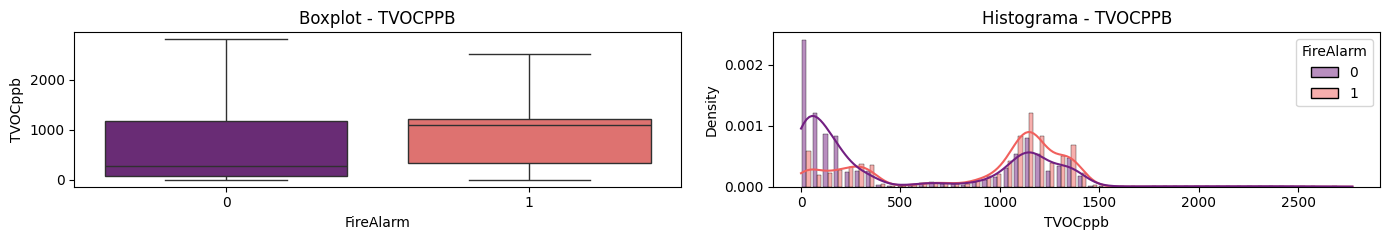

FireAlarm    count     mean       std  min    25%     50%     75%      max
0          0  35776.0  2737.47  10253.08  0.0   68.0   268.0  1166.0  60000.0
1          1  26854.0   882.37    546.55  0.0  332.0  1103.0  1208.0  18062.0

0.00  0.05   0.10    0.15   0.20   0.25   0.30   0.35    0.40  \
FireAlarm                                                                  
0           0.0   0.0   11.0   25.00   46.0   68.0   91.0  124.0   159.0   
1           0.0  38.0  121.0  207.95  278.0  332.0  639.0  931.0  1032.0   

             0.45    0.50     0.55    0.60    0.65    0.70    0.75    0.80  \
FireAlarm                                                                    
0           189.0   268.0   470.25   984.0  1084.0  1130.0  1166.0  1218.0   
1          1076.0  1103.0  1124.00  1141.0  1161.0  1182.0  1208.0  1245.0   

             0.85    0.90    0.95     1.00  
FireAlarm                                   
0          1320.0  1383.0  9123.0  60000.0  
1          1306.0  1343.0  1371.0  18062.0




>> Feature: eCO2ppm


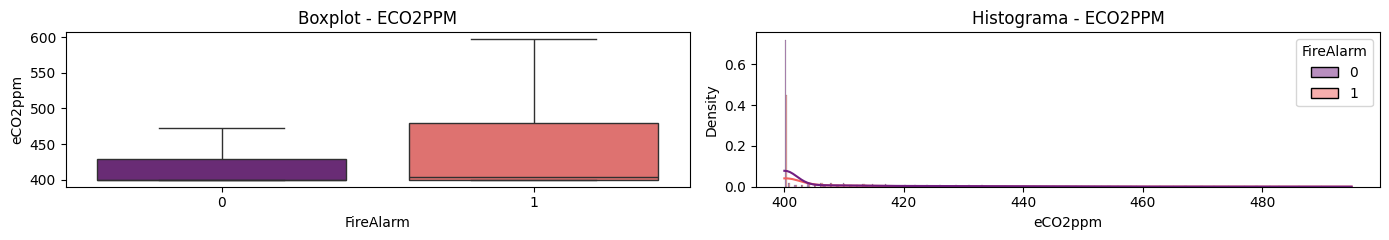

FireAlarm    count    mean      std    min    25%    50%    75%      max
0          0  35776.0  754.58  2218.37  400.0  400.0  400.0  429.0  51447.0
1          1  26854.0  557.37  1376.00  400.0  400.0  404.0  479.0  60000.0

0.00   0.05   0.10   0.15   0.20   0.25   0.30   0.35   0.40  \
FireAlarm                                                                  
0          400.0  400.0  400.0  400.0  400.0  400.0  400.0  400.0  400.0   
1          400.0  400.0  400.0  400.0  400.0  400.0  400.0  400.0  400.0   

            0.45   0.50   0.55   0.60   0.65   0.70   0.75   0.80    0.85  \
FireAlarm                                                                   
0          400.0  400.0  401.0  406.0  411.0  419.0  429.0  445.0  519.75   
1          400.0  404.0  408.0  413.0  420.0  434.0  479.0  532.0  577.00   

            0.90    0.95     1.00  
FireAlarm                          
0          610.0  738.25  51447.0  
1          643.0  714.00  60000.0




>> Feature: RawH2


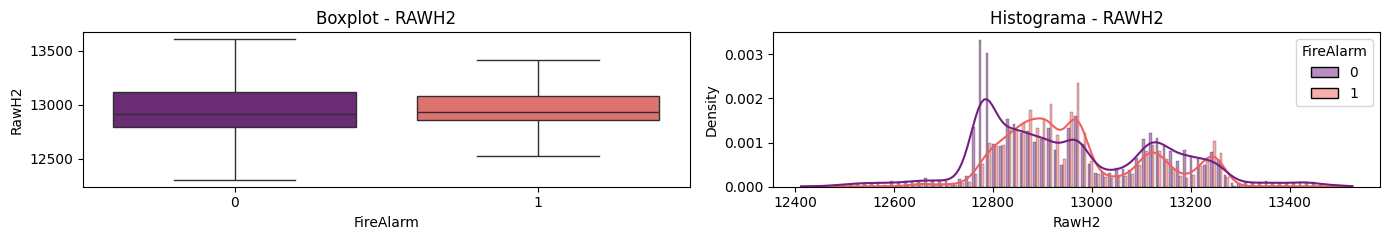

FireAlarm    count      mean     std      min      25%      50%       75%  \
0          0  35776.0  12928.71  329.10  10668.0  12794.0  12915.0  13119.25   
1          1  26854.0  12960.76  168.12  10939.0  12861.0  12932.0  13085.00   

       max  
0  13803.0  
1  13637.0

0.00     0.05     0.10      0.15     0.20     0.25     0.30  \
FireAlarm                                                                   
0          10668.0  12630.0  12766.0  12776.00  12785.0  12794.0  12821.0   
1          10939.0  12781.0  12805.0  12827.95  12845.0  12861.0  12875.0   

              0.35     0.40     0.45     0.50     0.55     0.60      0.65  \
FireAlarm                                                                   
0          12841.0  12864.0  12890.0  12915.0  12952.0  12972.0  13010.75   
1          12890.0  12905.0  12916.0  12932.0  12957.0  12967.0  12976.00   

              0.70      0.75     0.80     0.85     0.90     0.95     1.00  
FireAlarm                                                                  
0          13090.0  13119.25  13146.0  13186.0  13229.0  13299.0  13803.0  
1          12997.0  13085.00  13118.0  13144.0  13210.0  13246.0  13637.0




>> Feature: RawEthanol


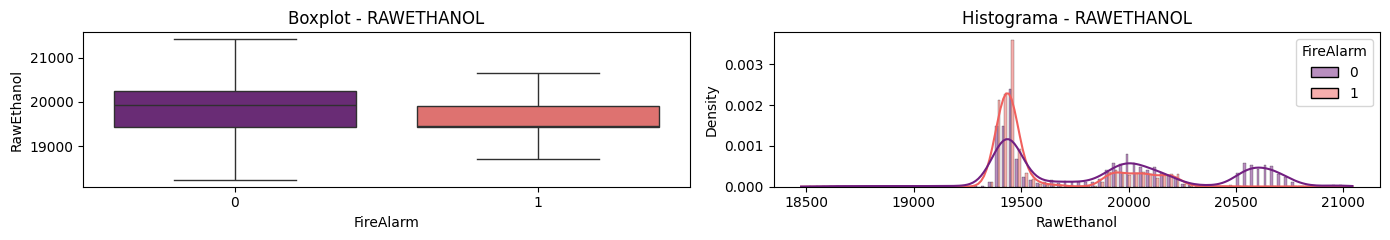

FireAlarm    count      mean     std      min      25%      50%      75%  \
0          0  35776.0  19852.66  746.01  15317.0  19443.0  19926.0  20245.0   
1          1  26854.0  19623.16  308.11  17817.0  19427.0  19454.0  19919.0   

       max  
0  21410.0  
1  21100.0

0.00     0.05     0.10     0.15     0.20     0.25     0.30  \
FireAlarm                                                                  
0          15317.0  19328.0  19392.0  19415.0  19433.0  19443.0  19454.0   
1          17817.0  19385.0  19392.0  19402.0  19417.0  19427.0  19434.0   

              0.35     0.40     0.45     0.50     0.55     0.60     0.65  \
FireAlarm                                                                  
0          19471.0  19549.0  19795.0  19926.0  19978.0  20016.0  20069.0   
1          19439.0  19444.0  19448.0  19454.0  19461.0  19472.0  19496.0   

              0.70     0.75     0.80     0.85     0.90      0.95     1.00  
FireAlarm                                                                  
0          20135.0  20245.0  20546.0  20598.0  20659.0  20737.00  21410.0  
1          19592.0  19919.0  19977.0  20047.0  20112.0  20192.35  21100.0




>> Feature: PressurehPa


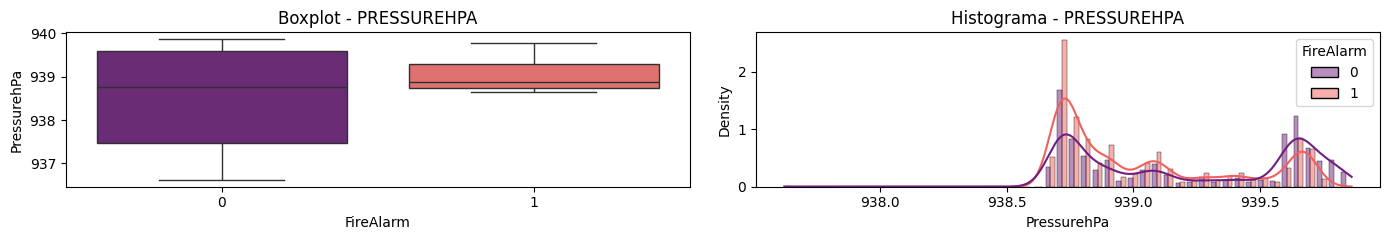

FireAlarm    count    mean   std     min     25%     50%     75%     max
0          0  35776.0  938.47  1.32  930.85  937.46  938.77  939.60  939.86
1          1  26854.0  938.83  1.32  930.85  938.73  938.88  939.29  939.77

0.00    0.05    0.10    0.15    0.20    0.25    0.30    0.35  \
FireAlarm                                                                   
0          930.85  936.80  936.91  937.34  937.40  937.46  937.54  938.69   
1          930.85  938.69  938.70  938.71  938.72  938.73  938.74  938.76   

             0.40    0.45    0.50    0.55    0.60    0.65    0.70    0.75  \
FireAlarm                                                                   
0          938.71  938.73  938.77  938.83  938.92  939.08  939.32  939.60   
1          938.79  938.82  938.88  938.91  939.02  939.08  939.13  939.29   

             0.80    0.85    0.90    0.95    1.00  
FireAlarm                                          
0          939.63  939.66  939.69  939.76  939.86  
1          939.44  939.61  939.66  939.68  939.77




>> Feature: NC05


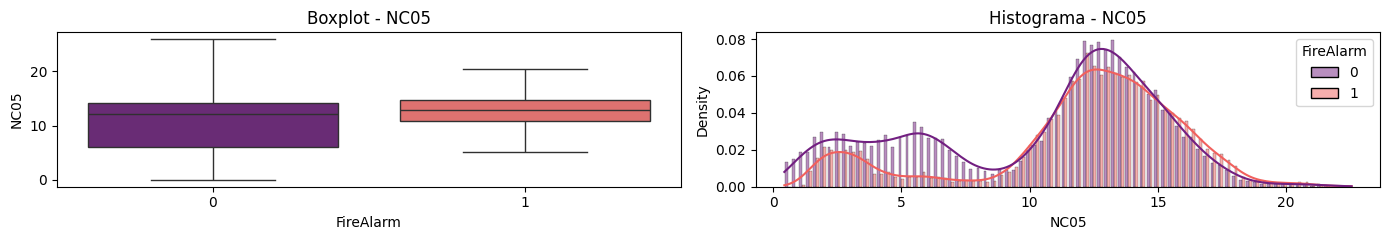

FireAlarm    count    mean      std   min    25%    50%    75%       max
0          0  35776.0  748.52  5300.28  0.00   6.10  12.12  14.12  61482.03
1          1  26854.0  149.00  2192.20  1.08  10.92  12.86  14.75  59301.19

0.00  0.05  0.10  0.15   0.20   0.25   0.30   0.35   0.40   0.45  \
FireAlarm                                                                     
0          0.00  1.65  2.72  3.97   5.16   6.10   7.42  10.14  11.11  11.69   
1          1.08  2.57  3.81  8.26  10.23  10.92  11.44  11.83  12.18  12.51   

            0.50   0.55   0.60   0.65   0.70   0.75   0.80   0.85   0.90  \
FireAlarm                                                                  
0          12.12  12.50  12.88  13.26  13.66  14.12  14.66  15.26  16.12   
1          12.86  13.21  13.57  13.95  14.32  14.75  15.23  15.80  16.43   

            0.95      1.00  
FireAlarm                   
0          17.91  61482.03  
1          17.48  59301.19




>> Feature: CNT


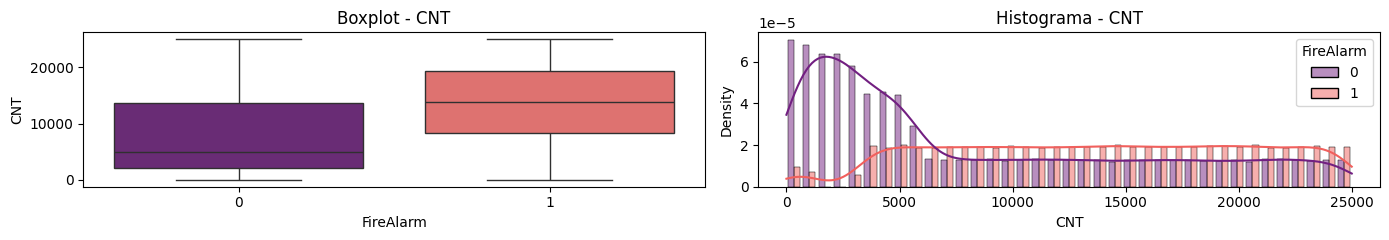

FireAlarm    count      mean      std  min     25%      50%      75%  \
0          0  35776.0   8070.73  7400.11  0.0  2118.0   4856.5  13724.0   
1          1  26854.0  13762.93  6570.56  3.0  8229.0  13872.0  19410.0   

       max  
0  24991.0  
1  24993.0

0.00    0.05    0.10     0.15    0.20    0.25    0.30      0.35  \
FireAlarm                                                                    
0           0.0   402.0   809.0  1224.00  1671.0  2118.0  2565.0   3012.25   
1           3.0  3727.3  4849.3  5957.95  7101.6  8229.0  9346.0  10472.55   

              0.40     0.45     0.50     0.55     0.60      0.65     0.70  \
FireAlarm                                                                   
0           3582.0   4224.0   4856.5   5502.0   7091.0   9313.75  11509.5   
1          11620.2  12747.0  13872.0  14952.0  16065.6  17189.00  18317.2   

              0.75     0.80      0.85     0.90      0.95     1.00  
FireAlarm                                                          
0          13724.0  16009.0  18223.75  20523.5  22715.25  24991.0  
1          19410.0  20514.4  21636.05  22780.7  23880.35  24993.0

In [93]:
for column in features_list_smoke:
    
    print("\n>> Feature:", column)
    function_plot_statistics(df_smoke, column, category='FireAlarm', palette='magma')
    print("\n")

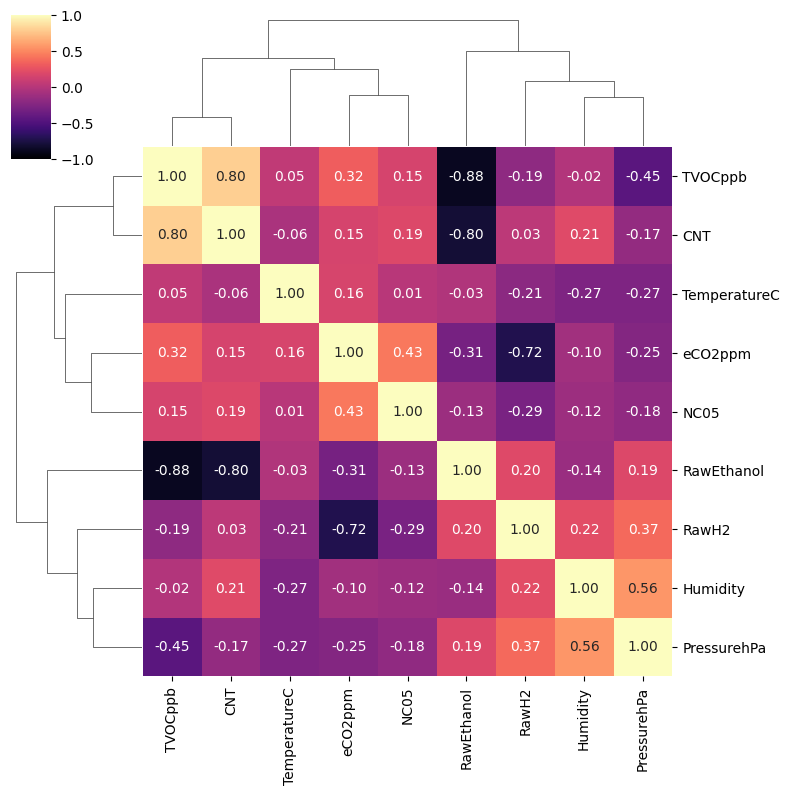

In [30]:
features_list_smoke = [col for col in features_list_smoke if col not in ['PM10', 'PM25', 'NC10', 'NC25']]
sns.clustermap(df_smoke[features_list_smoke].corr(method='spearman').round(2), figsize=(8, 8), annot=True, cmap='magma', fmt=".2f", vmin=-1, vmax=1)
plt.show()

# 4. Múltiplos modelos

## Busca comum de hiperparâmetros

In [31]:
param_AdaBoostClassifier = {"n_estimators": [50, 100, 200], 
                           "learning_rate": [0.01, 0.1, 0.2], 
                           }


param_XGBClassifier = {"n_estimators": [50, 100, 200], 
                       "max_depth": [3, 5, 7], 
                       "learning_rate": [0.01, 0.1, 0.2], 
                       "subsample": [0.8, 1.0]}

param_LGBMClassifier = {
    "n_estimators": [50, 100, 150, 180, 200, 250, 300], 
    "max_depth": [5, 10, 20, -1],  
    "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2], 
    "colsample_bytree": [0.5, 0.6, 0.7, 0.75, 0.8, 0.9],  
    "scale_pos_weight": [1, 3, 4, 5], 
    "reg_alpha": [0.0, 0.01, 0.03, 0.05, 0.1, 0.5, 1.0],  
    "reg_lambda": [0.0, 0.01, 0.03, 0.05, 0.1, 0.5, 1.0],  
    # "min_data_in_leaf": [20, 30, 40, 50, 100, 200]  
    "min_child_samples": [20, 30, 40, 50, 100, 200]  
}

param_LogisticRegression = {"C": [0.1, 1, 10]}

param_KNeighborsClassifier = {"n_neighbors": [3, 5, 7]}

param_DecisionTreeClassifier = {"max_depth": [3, 5, 7]}

param_RandomForestClassifier = {"n_estimators": [50, 100, 200]}

param_SVC = {"C": [0.1, 1, 10], 
             "kernel": ["linear", "rbf"]}

param_GradientBoostingClassifier = {"n_estimators": [50, 100, 200], 
                                    "learning_rate": [0.001, 0.01, 0.1, 0.2]}

param_MLPClassifier = {"hidden_layer_sizes": [(1,), (10,), (20,), (50,)], 
                       "alpha": [0.0001, 0.001]}

param_GaussianNB = {} 

## Crédito

In [32]:
df_classes_distribution_credit

loan_status  count  percentage
0            0  25473       78.18
1            1   7108       21.82


>> Etapa de split de dados:
> Dados de treino: 22806
> Dados de teste: 9775
> Taxa de dados de treino: 0.6999785150854793

>> Melhores hiperparâmetros:

> AdaBoostClassifier: {'n_estimators': 200, 'learning_rate': 0.2}

> XGBClassifier: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}


  File "C:\Users\carat\anaconda3\envs\ambiente_julia\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Number of positive: 4946, number of negative: 17860
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 22806, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.216873 -> initscore=-1.283984
[LightGBM] [Info] Start training from score -1.283984
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

> LGBMClassifier: {'scale_pos_weight': 1, 'reg_lambda': 0.01, 'reg_alpha': 0.1, 'n_estimators': 150, 'min_child_samples': 40, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.5}

> LogisticRegression: {'C': 0.1}

> KNeighborsClassifier: {'n_neighbors': 7}

> DecisionTree

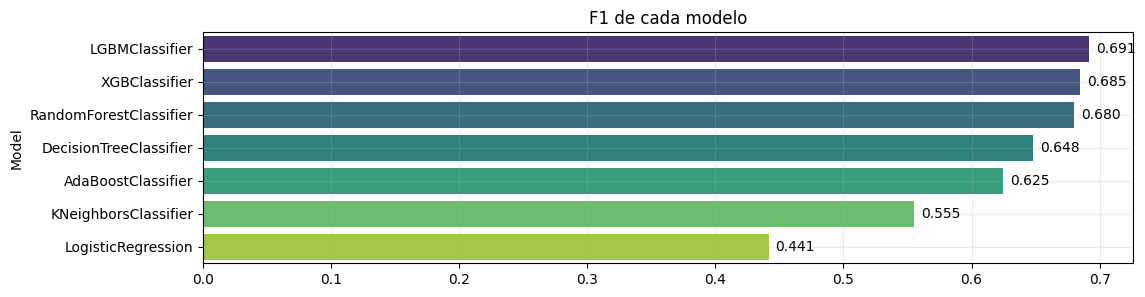

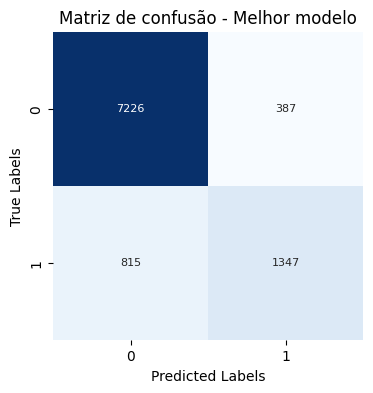

In [33]:
# Dados
X_credit = df_credit[numeric_features_list_credit]
y_credit = df_credit['loan_status']    

# Passo 1: Inicializar a classe PipelineMultiplosModelos
pipeline = PipelineMultiplosModelos(X_credit, y_credit, seed=42)

# Passo 2: Dividir os dados em treino e teste
pipeline.split_treino_teste(test_size=0.3, random_state=42)

# Passo 3: Encontrar os melhores hiperparâmetros para cada modelo
pipeline.busca_hiperparametros()

# Passo 4: Treinar os modelos com os melhores hiperparâmetros
pipeline.treino_teste_modelos()

# Passo 5: Visualizar as métricas de comparação de F1 entre os modelos
pipeline.metricas_ordenadas(palette='viridis')

# Passo 6: Visualizar a matriz de confusão do melhor modelo
pipeline.matriz_confusao_melhor_modelo()

## Smoke Detection - original

In [34]:
classes_distribution_smoke_original

FireAlarm  count  percentage
0          0  17873       28.54
1          1  44757       71.46


>> Etapa de split de dados:
> Dados de treino: 43841
> Dados de teste: 18789
> Taxa de dados de treino: 0.7

>> Melhores hiperparâmetros:

> AdaBoostClassifier: {'n_estimators': 200, 'learning_rate': 0.2}

> XGBClassifier: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.2}

> LGBMClassifier: {'scale_pos_weight': 1, 'reg_lambda': 1.0, 'reg_alpha': 0.0, 'n_estimators': 100, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.5}

> LogisticRegression: {'C': 0.1}

> KNeighborsClassifier: {'n_neighbors': 3}

> DecisionTreeClassifier: {'max_depth': 7}

> RandomForestClassifier: {'n_estimators': 50}

>> F1 de cada modelo:
> F1 do AdaBoostClassifier: 0.9999625594368939
> F1 do XGBClassifier: 0.9999625594368939
> F1 do LGBMClassifier: 0.9999625594368939
> F1 do LogisticRegression: 0.9916657238752499
> F1 do KNeighborsClassifier: 0.9997379553026616
> F1 do DecisionTreeClassifier: 1.0
> F1 do RandomForestClassifier: 1.0


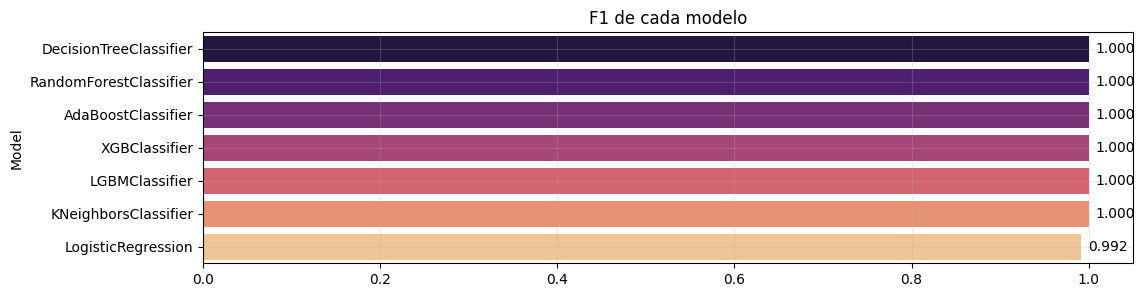

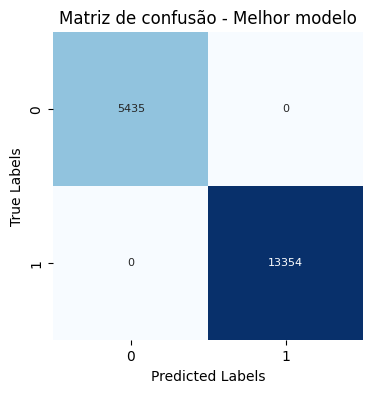

In [35]:
# Dados
X_smoke_original = df_smoke_original[features_list_smoke]
y_smoke_original = df_smoke_original['FireAlarm']    

# Passo 1: Inicializar a classe PipelineMultiplosModelos
pipeline = PipelineMultiplosModelos(X_smoke_original, y_smoke_original, seed=42)

# Passo 2: Dividir os dados em treino e teste
pipeline.split_treino_teste(test_size=0.3, random_state=42)

# Passo 3: Encontrar os melhores hiperparâmetros para cada modelo
pipeline.busca_hiperparametros()

# Passo 4: Treinar os modelos com os melhores hiperparâmetros
pipeline.treino_teste_modelos()

# Passo 5: Visualizar as métricas de comparação de F1 entre os modelos
pipeline.metricas_ordenadas(palette='magma')

# Passo 6: Visualizar a matriz de confusão do melhor modelo
pipeline.matriz_confusao_melhor_modelo()

## Smoke Detection - tratado

In [36]:
df_classes_distribution_smoke

FireAlarm  count  percentage
0          0  35776       57.12
1          1  26854       42.88


>> Etapa de split de dados:
> Dados de treino: 43841
> Dados de teste: 18789
> Taxa de dados de treino: 0.7

>> Melhores hiperparâmetros:

> AdaBoostClassifier: {'n_estimators': 200, 'learning_rate': 0.2}

> XGBClassifier: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01}

> LGBMClassifier: {'scale_pos_weight': 3, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'n_estimators': 50, 'min_child_samples': 100, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.5}

> LogisticRegression: {'C': 10}

> KNeighborsClassifier: {'n_neighbors': 7}

> DecisionTreeClassifier: {'max_depth': 7}

> RandomForestClassifier: {'n_estimators': 200}

>> F1 de cada modelo:
> F1 do AdaBoostClassifier: 0.7425211665098777
> F1 do XGBClassifier: 0.7435488411372807
> F1 do LGBMClassifier: 0.746371739231882
> F1 do LogisticRegression: 0.564228072496362
> F1 do KNeighborsClassifier: 0.6515332536837913
> F1 do DecisionTreeClassifier: 0.741366295527458
> F1 do RandomForestClassifier: 0.65589

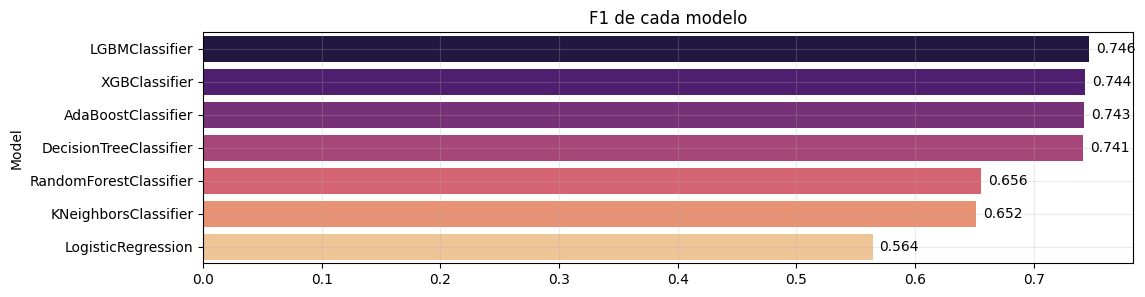

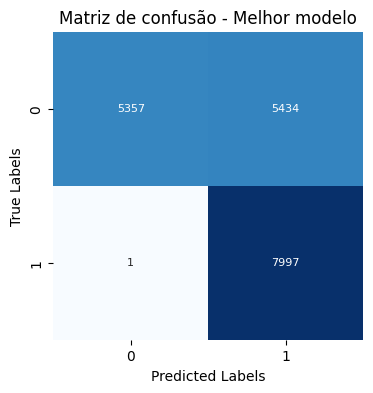

In [38]:
# Dados
X_smoke = df_smoke[features_list_smoke]
y_smoke = df_smoke['FireAlarm']    

# Passo 1: Inicializar a classe PipelineMultiplosModelos
pipeline = PipelineMultiplosModelos(X_smoke, y_smoke, seed=42)

# Passo 2: Dividir os dados em treino e teste
pipeline.split_treino_teste(test_size=0.3, random_state=42)

# Passo 3: Encontrar os melhores hiperparâmetros para cada modelo
pipeline.busca_hiperparametros()

# Passo 4: Treinar os modelos com os melhores hiperparâmetros
pipeline.treino_teste_modelos()

# Passo 5: Visualizar as métricas de comparação de F1 entre os modelos
pipeline.metricas_ordenadas(palette='magma')

# Passo 6: Visualizar a matriz de confusão do melhor modelo
pipeline.matriz_confusao_melhor_modelo()

# 5. LGBM - estudo de bibliotecas de otimização hiperparamétrica

## Padrão de treino

In [39]:
clf = LGBMClassifier() # Sem nada dentro, pois vamos "variar" os parâmetros.

param_LGBMClassifier = {
    "n_estimators": [50, 100, 150, 180, 200, 250 ,300], 
    "max_depth": [5, 10, 20, -1],  
    "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2], 
    "colsample_bytree": [0.5, 0.6, 0.7, 0.75, 0.8, 0.9],  
    "scale_pos_weight": [1, 3, 4, 5], 
    "reg_alpha": [0.0001, 0.01, 0.03, 0.05, 0.1, 0.5, 1.0],  
    "reg_lambda": [0.0001, 0.01, 0.03, 0.05, 0.1, 0.5, 1.0],  
    "min_data_in_leaf": [20, 30, 40, 50, 100, 200]  
}

## Credit

In [40]:
df_classes_distribution_credit

loan_status  count  percentage
0            0  25473       78.18
1            1   7108       21.82

In [41]:
# Dados
X_credit = df_credit[numeric_features_list_credit]
y_credit = df_credit['loan_status']

# Divisão de teste e treino
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(X_credit, y_credit, test_size=0.3, random_state=42)

In [42]:
#------------------------ RandomizedSearchCV no LGBM ------------------------#

# Cria modelo
credit_lgbm_random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_LGBMClassifier, n_jobs=-1, scoring='f1', cv=5, verbose=0)

# Fit nos dados de treino
credit_lgbm_random_search.fit(X_train_credit, y_train_credit)

# Print do melhor treino
print('\n> best_params:', credit_lgbm_random_search.best_params_)
print('\n> best_score:', credit_lgbm_random_search.best_score_)
print('\n> best_estimator:', credit_lgbm_random_search.best_estimator_)

# Gera predições
y_pred_credit_random_search = credit_lgbm_random_search.predict(X_test_credit)
print('\n> Classification report:', classification_report(y_test_credit, y_pred_credit_random_search))

# Salva tentativas do random_search
CV_results_df_random_search = pd.DataFrame(credit_lgbm_random_search.cv_results_)
CV_results_df_random_search.drop(columns=['params']).sort_values(by='mean_test_score', ascending=False).head()


> best_params: {'scale_pos_weight': 4, 'reg_lambda': 0.1, 'reg_alpha': 0.05, 'n_estimators': 300, 'min_data_in_leaf': 40, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.8}

> best_score: 0.6865902692934314

> best_estimator: LGBMClassifier(colsample_bytree=0.8, max_depth=10, min_data_in_leaf=40,
               n_estimators=300, reg_alpha=0.05, reg_lambda=0.1,
               scale_pos_weight=4)

> Classification report:               precision    recall  f1-score   support

           0       0.94      0.86      0.90      7613
           1       0.62      0.80      0.70      2162

    accuracy                           0.85      9775
   macro avg       0.78      0.83      0.80      9775
weighted avg       0.87      0.85      0.85      9775



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      15.557928      0.340318         0.102900        0.029037   
8      15.472255      2.390237         0.125884        0.018365   
3      19.473806      2.226311         0.139391        0.006768   
2       2.124783      0.646463         0.034099        0.038651   
6      18.242950      0.385037         0.073679        0.025776   

   param_scale_pos_weight  param_reg_lambda  param_reg_alpha  \
0                       4            0.1000           0.0500   
8                       3            0.0300           0.5000   
3                       1            0.1000           1.0000   
2                       4            0.0300           0.0001   
6                       5            0.0001           0.5000   

   param_n_estimators  param_min_data_in_leaf  param_max_depth  \
0                 300                      40               10   
8                 250                     200               10   
3                 300                     100               20   
2                 150                     200               10   
6                 200                      40               10   

   param_learning_rate  param_colsample_bytree  split0_test_score  \
0                 0.10                     0.8           0.689563   
8                 0.05                     0.7           0.694622   
3                 0.10                     0.5           0.670773   
2                 0.10                     0.8           0.680887   
6                 0.10                     0.5           0.676975   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.700749           0.687642           0.677649           0.677348   
8           0.703069           0.670980           0.690628           0.663406   
3           0.702174           0.660249           0.675399           0.668882   
2           0.684677           0.665234           0.672377           0.657707   
6           0.681310           0.667235           0.672241           0.661716   

   mean_test_score  std_test_score  rank_test_score  
0         0.686590        0.008669                1  
8         0.684541        0.014917                2  
3         0.675495        0.014214                3  
2         0.672176        0.009897                4  
6         0.671895        0.006926                5

In [43]:
#------------------------ # TPE Optuna para LGBM ------------------------#

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = optuna.samplers.TPESampler(multivariate=True, # Multivariate TPE is used when suggesting parameters
                                     group=True) # The sampling algorithm decomposes the search space based on past trials 

study = optuna.create_study(sampler=sampler, direction='maximize')

study.optimize(lambda trial: optuna_objective_function(trial, X_train_credit, X_test_credit, y_train_credit, y_test_credit), n_trials=50)

print('\n> Melhores hiperparâmetros:', study.best_params) # = study.best_trial.params
print('\n> Melhor F1:', study.best_value,'\n')

df_tentativas_credit = study.trials_dataframe().drop(columns=['datetime_start','datetime_complete','duration','state'])
df_tentativas_credit.sort_values(by='value', ascending=False).head()


> Melhores hiperparâmetros: {'n_estimators': 160, 'max_depth': 11, 'learning_rate': 0.11291096712319347, 'colsample_bytree': 0.6859845880735984, 'scale_pos_weight': 2, 'lambda_l1': 0.005651326745292381, 'lambda_l2': 0.45690041096959555, 'min_data_in_leaf': 33}

> Melhor F1: 0.7118333714808881 



number     value  params_colsample_bytree  params_lambda_l1  \
44      44  0.711833                 0.685985          0.005651   
40      40  0.709721                 0.961889          0.072060   
29      29  0.709284                 0.980057          0.238978   
4        4  0.709124                 0.998382          0.026617   
23      23  0.708658                 0.945574          0.055278   

    params_lambda_l2  params_learning_rate  params_max_depth  \
44          0.456900              0.112911                11   
40          0.002368              0.102567                11   
29          0.010422              0.130900                15   
4           0.016087              0.192680                10   
23          0.158421              0.187947                 6   

    params_min_data_in_leaf  params_n_estimators  params_scale_pos_weight  
44                       33                  160                        2  
40                      133                  182                        2  
29                      160                  184                        2  
4                       161                  189                        2  
23                      113                  155                        2

## Smoke Detection

In [44]:
df_classes_distribution_smoke

FireAlarm  count  percentage
0          0  35776       57.12
1          1  26854       42.88

In [45]:
# Aqui, o random seach ficou melhor que a otimização bayesiana

# É estranho? Geralmente qual fica melhor? Tem que testar?

In [46]:
# Dados
X_smoke = df_smoke[features_list_smoke]
y_smoke = df_smoke['FireAlarm']

# Divisão de teste e treino
X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke = train_test_split(X_smoke, y_smoke, test_size=0.3, random_state=42)

In [47]:
#------------------------ RandomizedSearchCV no LGBM ------------------------#

# Cria modelo
smoke_lgbm_random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_LGBMClassifier, n_jobs=-1, scoring='f1', cv=5, verbose=0)

# Fit nos dados de treino
smoke_lgbm_random_search.fit(X_train_smoke, y_train_smoke)

# Print do melhor treino
print('\n> best_params:', smoke_lgbm_random_search.best_params_)
print('\n> best_score:', smoke_lgbm_random_search.best_score_)
print('\n> best_estimator:', smoke_lgbm_random_search.best_estimator_)

# Gera predições
y_pred_smoke_random_search = smoke_lgbm_random_search.predict(X_test_smoke)
print('\n> Classification report:', classification_report(y_test_smoke, y_pred_smoke_random_search))

# Salva tentativas do random_search
CV_results_df_random_search = pd.DataFrame(smoke_lgbm_random_search.cv_results_)
CV_results_df_random_search.drop(columns=['params']).sort_values(by='mean_test_score', ascending=False).head()


> best_params: {'scale_pos_weight': 4, 'reg_lambda': 0.03, 'reg_alpha': 0.01, 'n_estimators': 100, 'min_data_in_leaf': 200, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.5}

> best_score: 0.751287722367524

> best_estimator: LGBMClassifier(colsample_bytree=0.5, max_depth=5, min_data_in_leaf=200,
               reg_alpha=0.01, reg_lambda=0.03, scale_pos_weight=4)

> Classification report:               precision    recall  f1-score   support

           0       1.00      0.50      0.66     10791
           1       0.60      1.00      0.75      7998

    accuracy                           0.71     18789
   macro avg       0.80      0.75      0.70     18789
weighted avg       0.83      0.71      0.70     18789



mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       8.711450      0.323058         0.157180        0.061236   
3      16.887429      0.635798         0.123737        0.015917   
1       3.942776      0.468501         0.032915        0.007703   
4      32.358702      2.002691         0.169912        0.018859   
9       6.183312      0.589649         0.066083        0.018240   

   param_scale_pos_weight  param_reg_lambda  param_reg_alpha  \
0                       4              0.03             0.01   
3                       4              0.10             0.10   
1                       4              1.00             0.05   
4                       4              0.05             0.03   
9                       4              0.05             0.03   

   param_n_estimators  param_min_data_in_leaf  param_max_depth  \
0                 100                     200                5   
3                 180                      20                5   
1                  50                      40                5   
4                 200                     200               10   
9                 100                     100                5   

   param_learning_rate  param_colsample_bytree  split0_test_score  \
0                 0.10                     0.5           0.753974   
3                 0.01                     0.6           0.753447   
1                 0.05                     0.8           0.753070   
4                 0.10                     0.8           0.753426   
9                 0.01                     0.9           0.753070   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.751345           0.747695           0.753699           0.749726   
3           0.751345           0.747695           0.753849           0.749652   
1           0.751195           0.747547           0.753397           0.749826   
4           0.750474           0.747817           0.753429           0.749751   
9           0.751195           0.747473           0.753397           0.749751   

   mean_test_score  std_test_score  rank_test_score  
0         0.751288        0.002382                1  
3         0.751197        0.002314                2  
1         0.751007        0.002162                3  
4         0.750979        0.002179                4  
9         0.750977        0.002194                5

In [48]:
#------------------------ # TPE Optuna para LGBM ------------------------#

optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = optuna.samplers.TPESampler(multivariate=True, # Multivariate TPE is used when suggesting parameters
                                     group=True) # The sampling algorithm decomposes the search space based on past trials 

study = optuna.create_study(sampler=sampler, direction='maximize')

study.optimize(lambda trial: optuna_objective_function(trial, X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke), n_trials=50)

print('\n> Melhores hiperparâmetros:', study.best_params) # = study.best_trial.params
print('\n> Melhor F1:', study.best_value,'\n')

df_tentativas_smoke = study.trials_dataframe().drop(columns=['datetime_start','datetime_complete','duration','state'])
df_tentativas_smoke.sort_values(by='value', ascending=False).head()


> Melhores hiperparâmetros: {'n_estimators': 105, 'max_depth': -1, 'learning_rate': 0.11931491804923082, 'colsample_bytree': 0.6647064247282226, 'scale_pos_weight': 5, 'lambda_l1': 0.21230046954523935, 'lambda_l2': 0.33031632929332105, 'min_data_in_leaf': 198}

> Melhor F1: 0.7464065708418891 



number     value  params_colsample_bytree  params_lambda_l1  \
24      24  0.746407                 0.664706          0.212300   
25      25  0.746395                 0.572223          0.396545   
13      13  0.746395                 0.650481          0.011586   
34      34  0.746395                 0.619745          0.098874   
37      37  0.746394                 0.632874          0.004259   

    params_lambda_l2  params_learning_rate  params_max_depth  \
24          0.330316              0.119315                -1   
25          0.307350              0.130084                 0   
13          0.299064              0.094685                 0   
34          0.000666              0.059099                 0   
37          0.469072              0.156903                -1   

    params_min_data_in_leaf  params_n_estimators  params_scale_pos_weight  
24                      198                  105                        5  
25                      182                   82                        5  
13                      183                   71                        5  
34                      159                  116                        3  
37                      182                   88                        4

# 6. Estudo de hiperparâmetros - LGBM, XGboost, AdaBoost

In [49]:
X_credit = df_credit[numeric_features_list_credit]
y_credit = df_credit['loan_status']
X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(X_credit, y_credit, test_size=0.3, random_state=42)

#------------------------------------------------------------------------------------------------------------------------------------#

X_smoke = df_smoke[features_list_smoke]
y_smoke = df_smoke['FireAlarm']
X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke = train_test_split(X_smoke, y_smoke, test_size=0.3, random_state=42)

In [50]:
df_classes_distribution_credit

loan_status  count  percentage
0            0  25473       78.18
1            1   7108       21.82

In [51]:
df_classes_distribution_smoke

FireAlarm  count  percentage
0          0  35776       57.12
1          1  26854       42.88

## learning_rate
- Controla a taxa de atualização dos pesos
- O learning rate determina o tamanho do passo dado na direção do gradiente
- Se o gradiente indica que o parâmetro deve ser ajustado em uma certa direção, o learning rate controla quanto mudar o parâmetro nessa direção
- Se o valor do learning rate for muito alto, o modelo pode dar passos grandes demais ao longo da superfície da função de perda, pulando o ponto ótimo
- Quanto mais baixo, mais conservador

In [52]:
learning_rates_test = [1e-20, 1e-19, 1e-18, 1e-17, 1e-16, 1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 1e-10, 
                       1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3,
                       0.01, 0.05, 
                       0.1, 0.2, 0.3, 
                       # 0.5, 0.6, 0.7, 0.8, 0.9, 1
                      ]

In [53]:
############ Credit

>> Hiperparâmetro: learning_rate
>> Modelo: AdaBoost


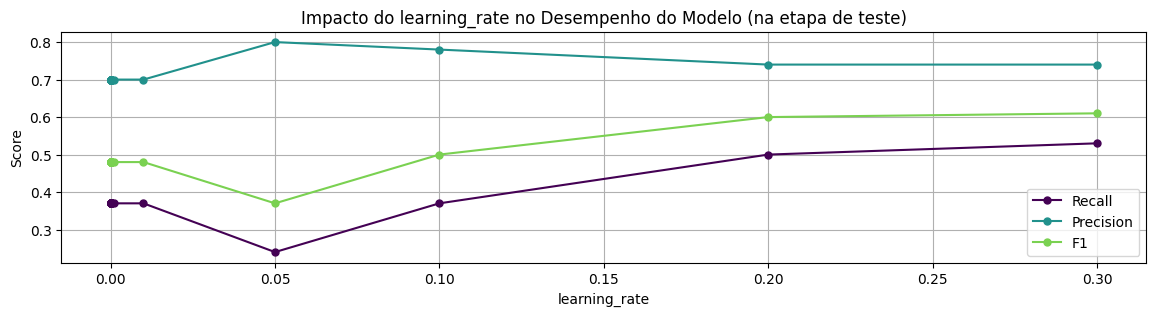

>> Hiperparâmetro: learning_rate
>> Modelo: AdaBoost


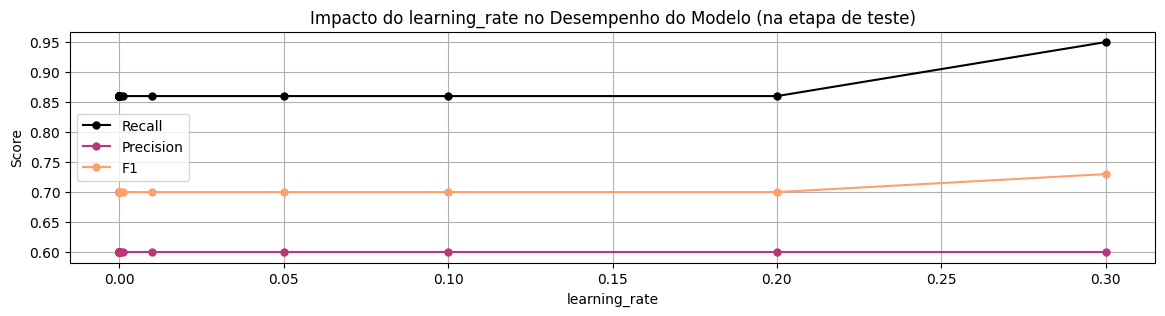

In [54]:
credit_result_df = AdaBoost_hyperparams_test(learning_rates_test, 'learning_rate',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = AdaBoost_hyperparams_test(learning_rates_test, 'learning_rate',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

>> Hiperparâmetro: learning_rate
>> Modelo: XGBoost


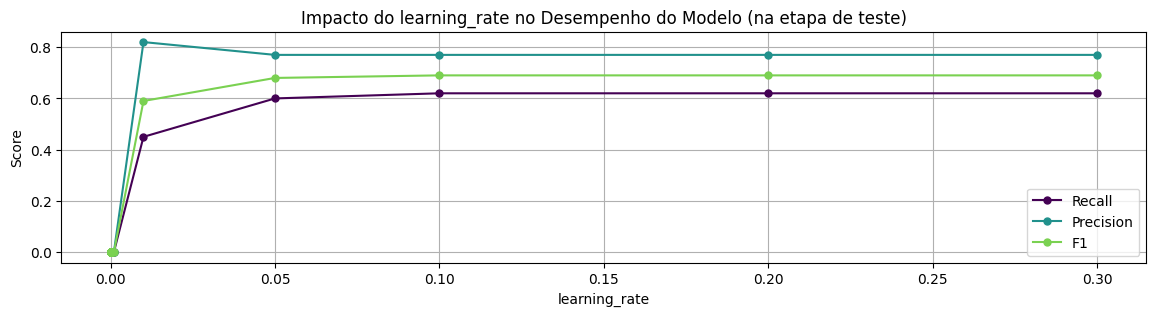

>> Hiperparâmetro: learning_rate
>> Modelo: XGBoost


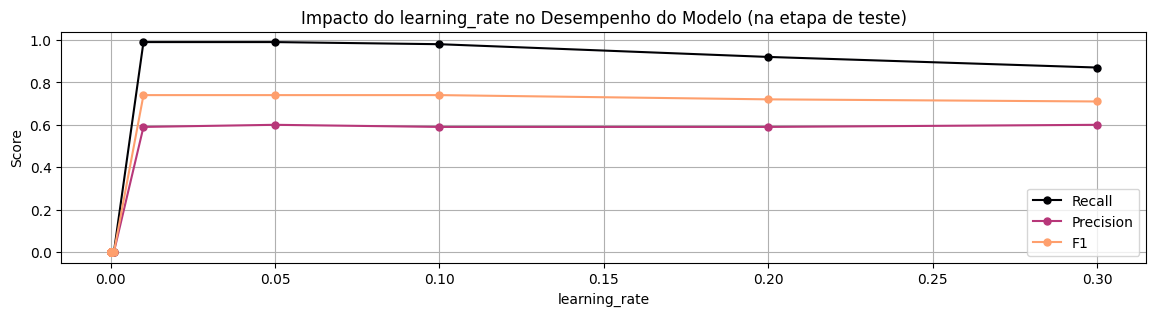

In [55]:
credit_result_df = XGBClassifier_hyperparams_test(learning_rates_test, 'learning_rate',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = XGBClassifier_hyperparams_test(learning_rates_test, 'learning_rate',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

>> Hiperparâmetro: learning_rate
>> Modelo: LGBM


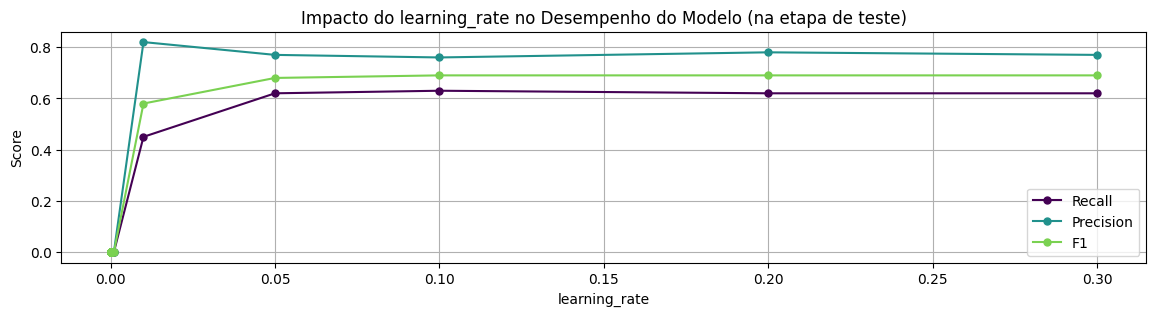

>> Hiperparâmetro: learning_rate
>> Modelo: LGBM


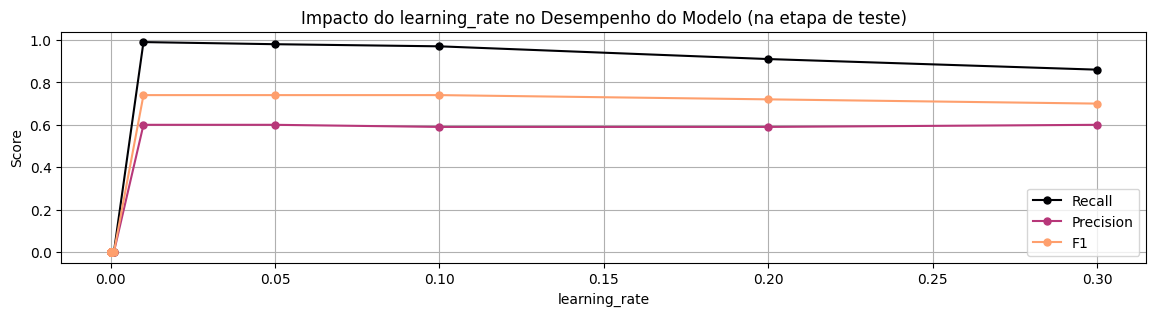

In [56]:
credit_result_df = LGBM_hyperparams_test(learning_rates_test, 'learning_rate',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = LGBM_hyperparams_test(learning_rates_test, 'learning_rate',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

## num_iterations
- Controla o número de rodadas boosting, ou seja, número de árvores


>> Hiperparâmetro: num_iterations
>> Modelo: XGBoost


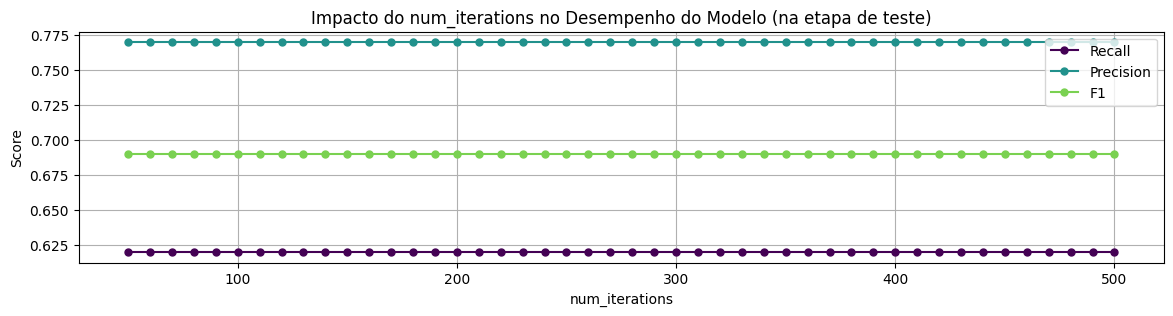

>> Hiperparâmetro: num_iterations
>> Modelo: XGBoost


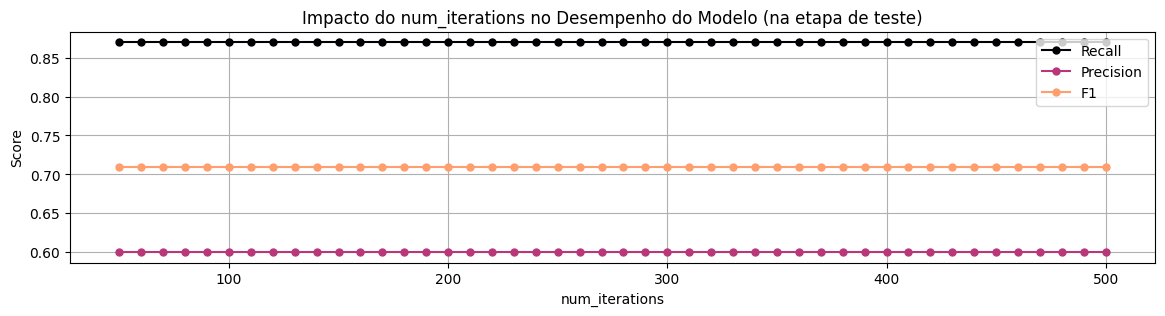

In [57]:
num_iterations_test = np.arange(50, 501, 10)

credit_result_df = XGBClassifier_hyperparams_test(num_iterations_test, 'num_iterations',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = XGBClassifier_hyperparams_test(num_iterations_test, 'num_iterations',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

>> Hiperparâmetro: num_iterations
>> Modelo: LGBM


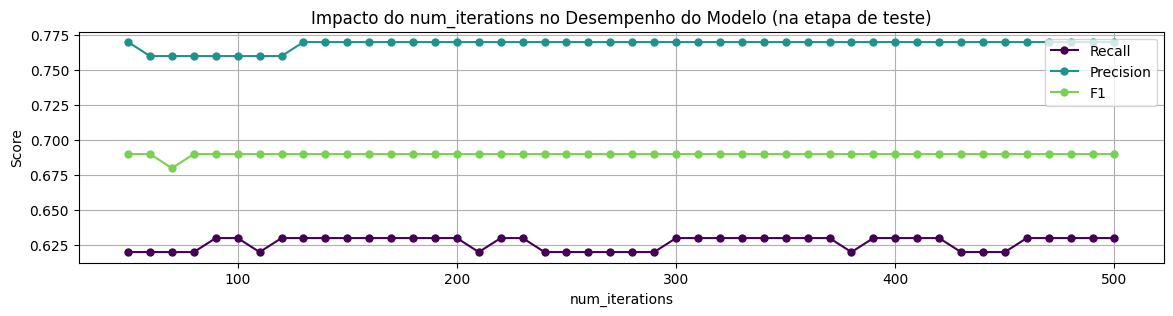

>> Hiperparâmetro: num_iterations
>> Modelo: LGBM


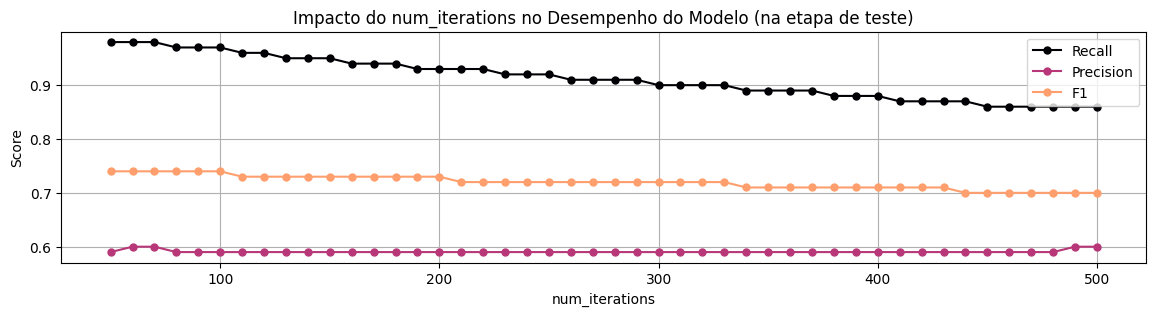

In [58]:
num_iterations_test = np.arange(50, 501, 10)

credit_result_df = LGBM_hyperparams_test(num_iterations_test, 'num_iterations',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = LGBM_hyperparams_test(num_iterations_test, 'num_iterations',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

## n_estimators/num_iteration
- Número de árvores sequenciais 
- "Um valor mais alto significa que mais aprendizes fracos contribuem para a saída final, mas aumentá-lo desacelera significativamente o tempo de treinamento."

In [59]:
n_estimators_test = np.arange(10, 301, 10)

>> Hiperparâmetro: n_estimators
>> Modelo: AdaBoost


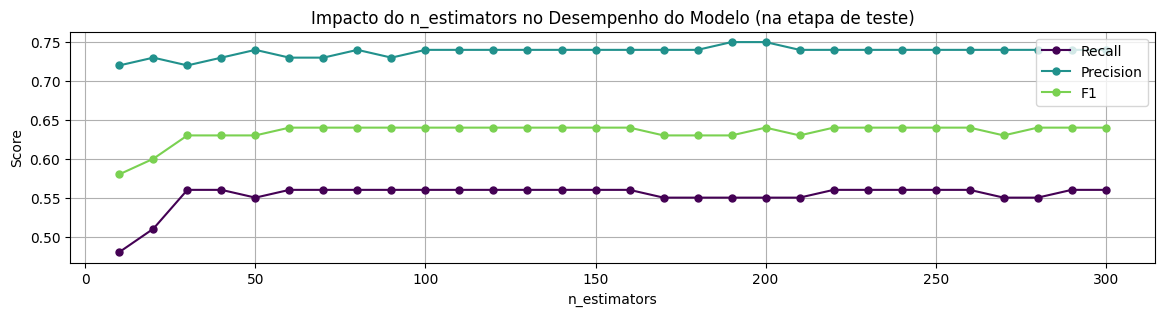

>> Hiperparâmetro: n_estimators
>> Modelo: AdaBoost


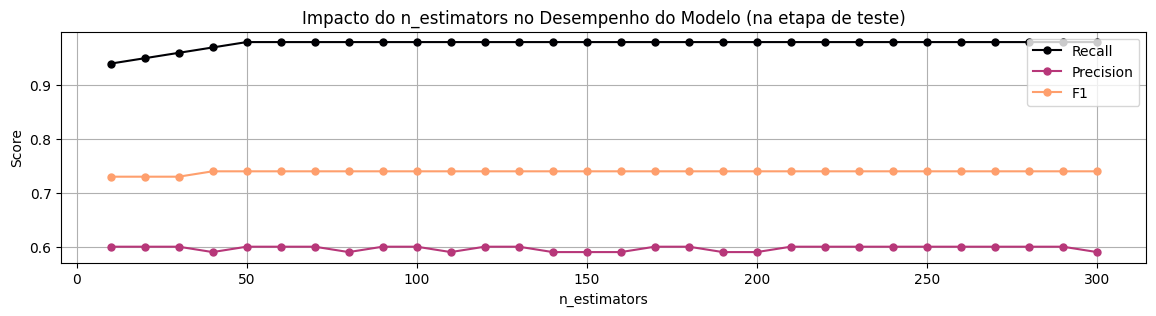

In [60]:
credit_result_df = AdaBoost_hyperparams_test(n_estimators_test, 'n_estimators',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = AdaBoost_hyperparams_test(n_estimators_test, 'n_estimators',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

>> Hiperparâmetro: n_estimators
>> Modelo: XGBoost


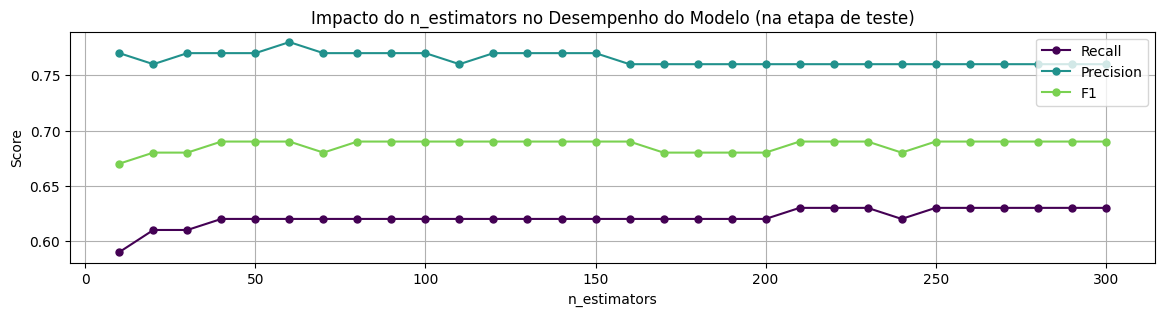

>> Hiperparâmetro: n_estimators
>> Modelo: XGBoost


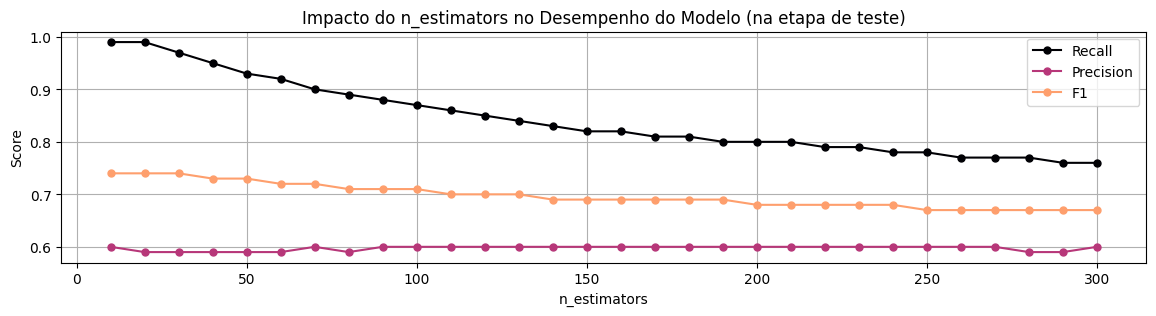

In [61]:
credit_result_df = XGBClassifier_hyperparams_test(n_estimators_test, 'n_estimators',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = XGBClassifier_hyperparams_test(n_estimators_test, 'n_estimators',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

>> Hiperparâmetro: n_estimators
>> Modelo: LGBM


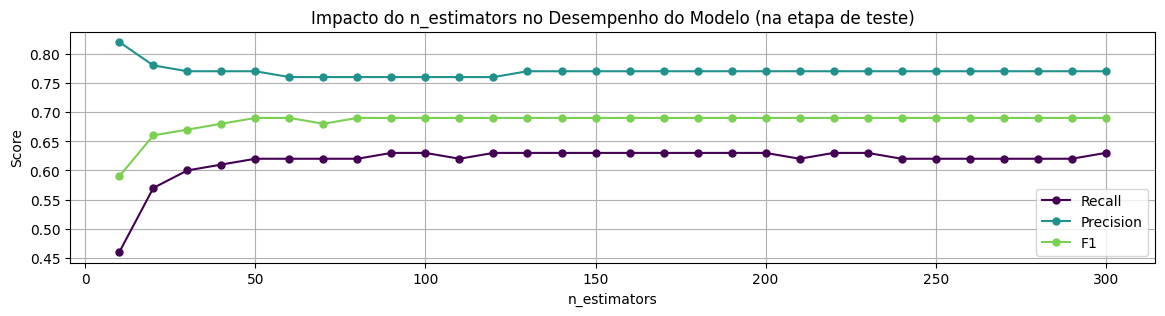

>> Hiperparâmetro: n_estimators
>> Modelo: LGBM


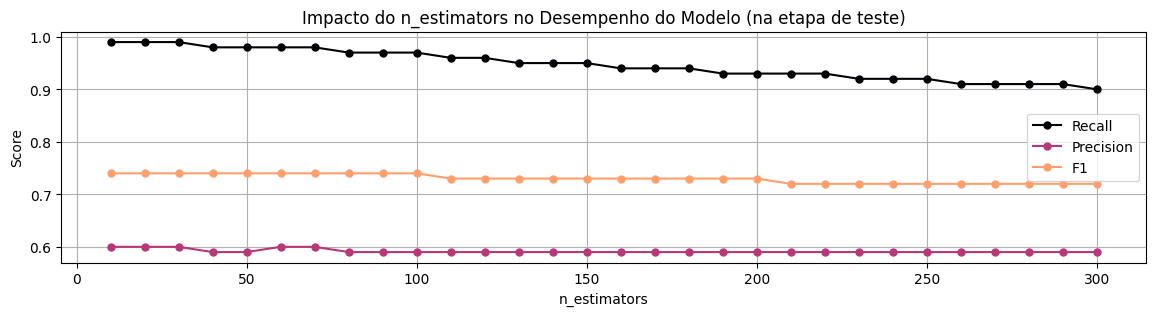

In [62]:
credit_result_df = LGBM_hyperparams_test(n_estimators_test, 'n_estimators',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = LGBM_hyperparams_test(n_estimators_test, 'n_estimators',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

## scale_pos_weight
- Controla o equilíbrio de pesos positivos e negativos, útil para classes desbalanceadas

In [63]:
df_classes_distribution_credit

loan_status  count  percentage
0            0  25473       78.18
1            1   7108       21.82

In [64]:
df_classes_distribution_smoke

FireAlarm  count  percentage
0          0  35776       57.12
1          1  26854       42.88

>> Hiperparâmetro: scale_pos_weight
>> Modelo: LGBM


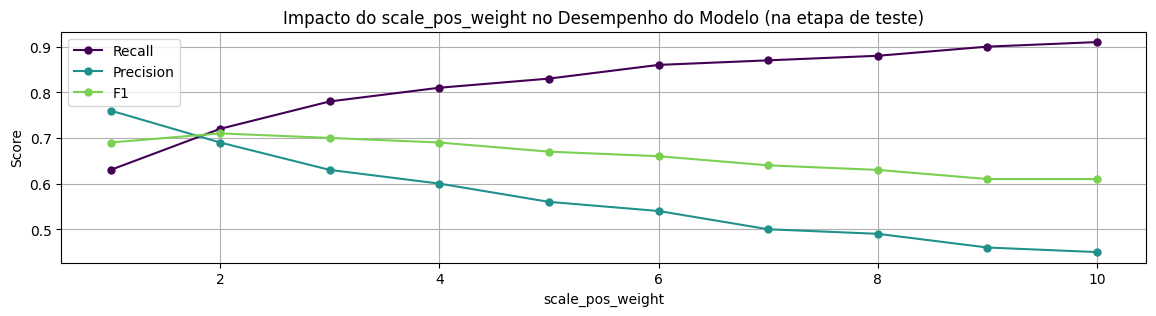

>> Hiperparâmetro: scale_pos_weight
>> Modelo: LGBM


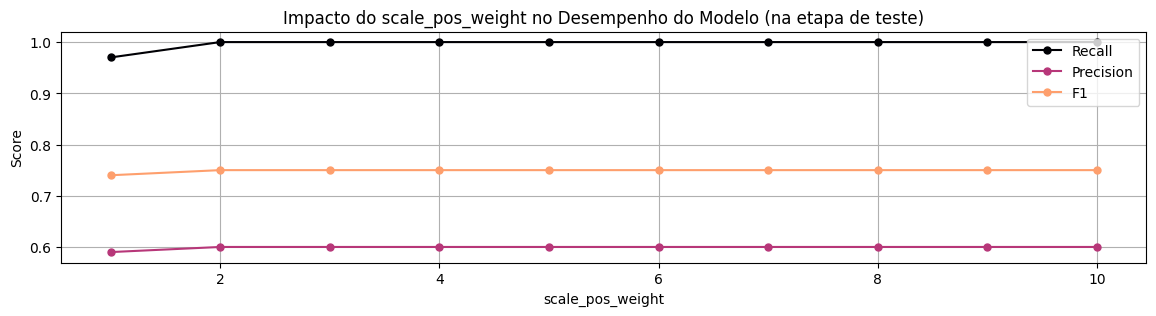

In [65]:
scale_pos_weight_test = np.arange(1, 11, 1)

credit_result_df = LGBM_hyperparams_test(scale_pos_weight_test, 'scale_pos_weight',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = LGBM_hyperparams_test(scale_pos_weight_test, 'scale_pos_weight',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

>> Hiperparâmetro: scale_pos_weight
>> Modelo: XGBoost


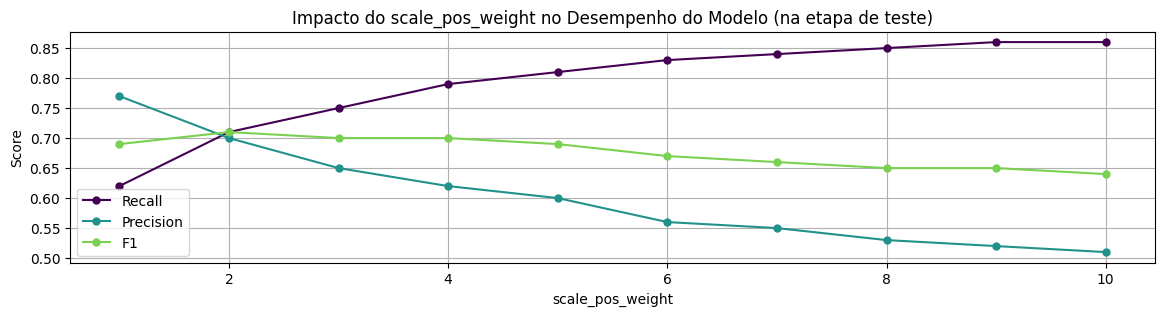

>> Hiperparâmetro: scale_pos_weight
>> Modelo: XGBoost


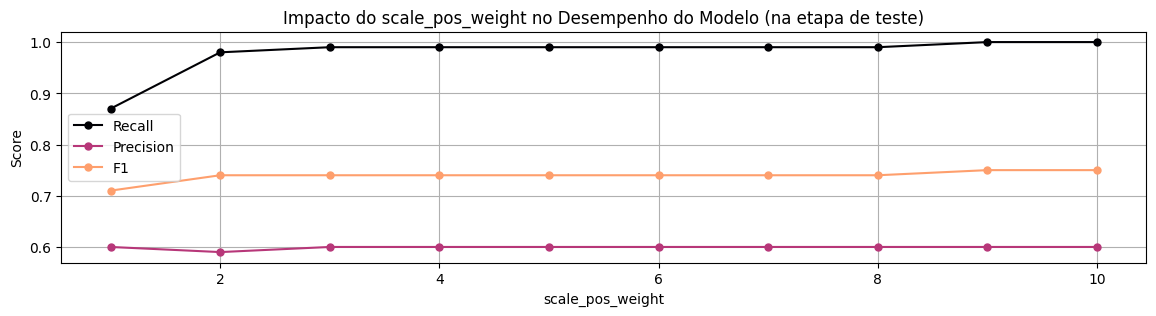

In [66]:
scale_pos_weight_test = np.arange(1, 11, 1)

credit_result_df = XGBClassifier_hyperparams_test(scale_pos_weight_test, 'scale_pos_weight',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = XGBClassifier_hyperparams_test(scale_pos_weight_test, 'scale_pos_weight',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

## max_depth
- Profundidade máxima de uma árvore

>> Hiperparâmetro: max_depth
>> Modelo: LGBM


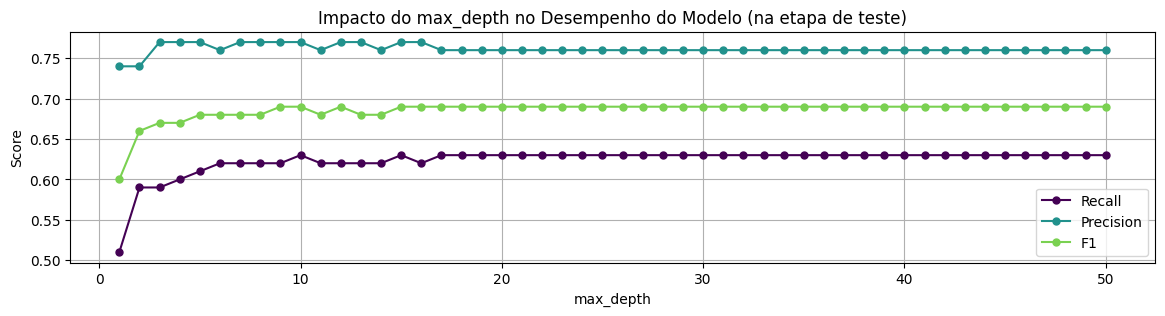

>> Hiperparâmetro: max_depth
>> Modelo: LGBM


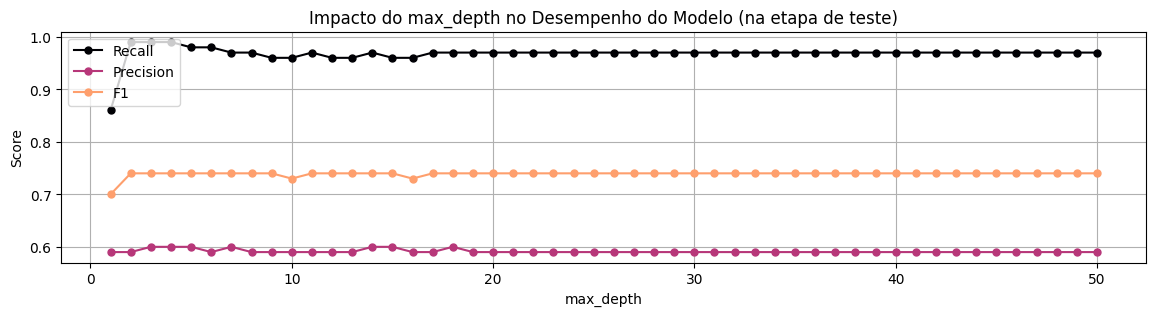

In [67]:
max_depth_test = np.arange(1, 51, 1)

credit_result_df = LGBM_hyperparams_test(max_depth_test, 'max_depth',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = LGBM_hyperparams_test(max_depth_test, 'max_depth',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

>> Hiperparâmetro: max_depth
>> Modelo: XGBoost


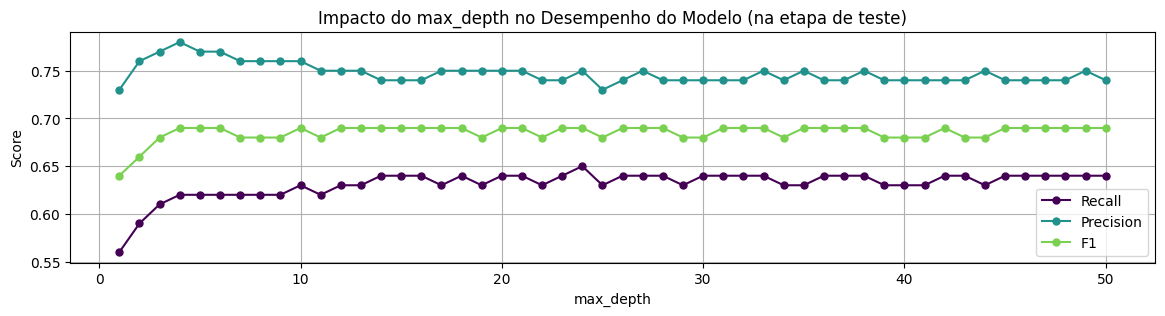

>> Hiperparâmetro: max_depth
>> Modelo: XGBoost


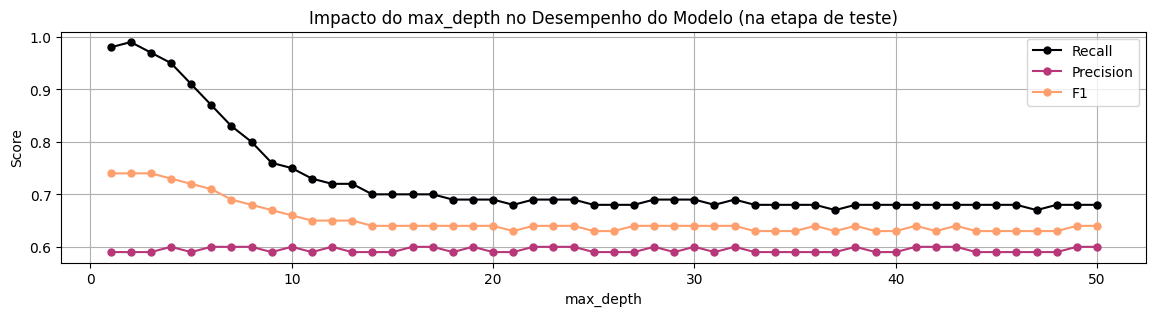

In [68]:
max_depth_test = np.arange(1, 51, 1)

credit_result_df = XGBClassifier_hyperparams_test(max_depth_test, 'max_depth',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = XGBClassifier_hyperparams_test(max_depth_test, 'max_depth',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

## colsample_bytree/feature_fraction
- Porcentagem de parâmetros selecionados em cada iteração (com resampling)


In [69]:
colsample_bytree_test = np.arange(0.1, 1.1, 0.1)

In [70]:
df_classes_distribution_credit

loan_status  count  percentage
0            0  25473       78.18
1            1   7108       21.82

In [71]:
df_classes_distribution_smoke

FireAlarm  count  percentage
0          0  35776       57.12
1          1  26854       42.88

>> Hiperparâmetro: colsample_bytree
>> Modelo: LGBM


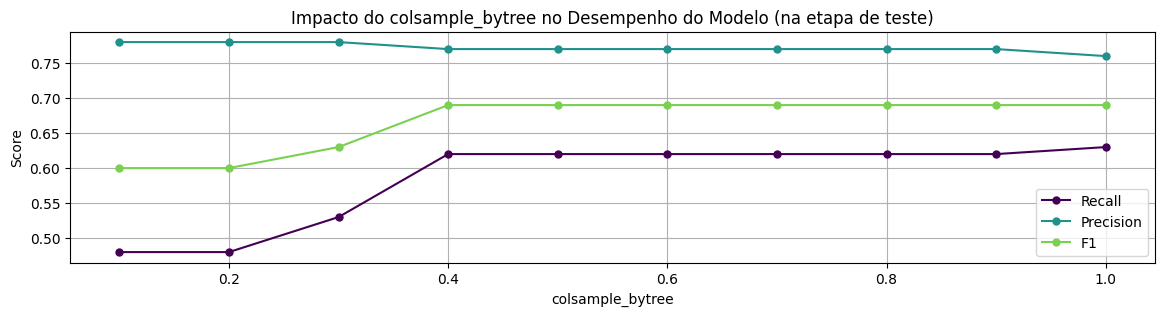

>> Hiperparâmetro: colsample_bytree
>> Modelo: LGBM


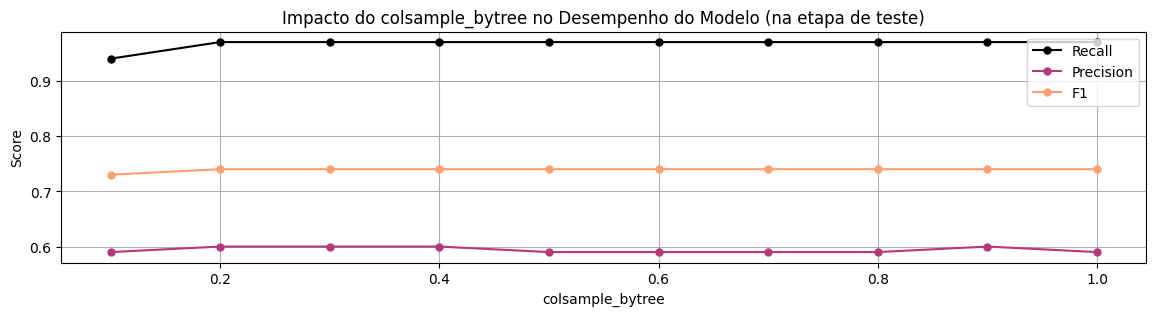

In [72]:
credit_result_df = LGBM_hyperparams_test(colsample_bytree_test, 'colsample_bytree',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = LGBM_hyperparams_test(colsample_bytree_test, 'colsample_bytree',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

>> Hiperparâmetro: colsample_bytree
>> Modelo: XGBoost


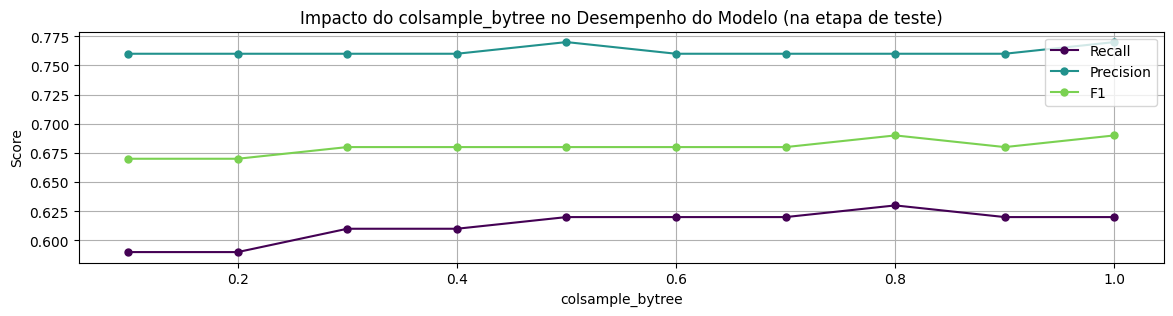

>> Hiperparâmetro: colsample_bytree
>> Modelo: XGBoost


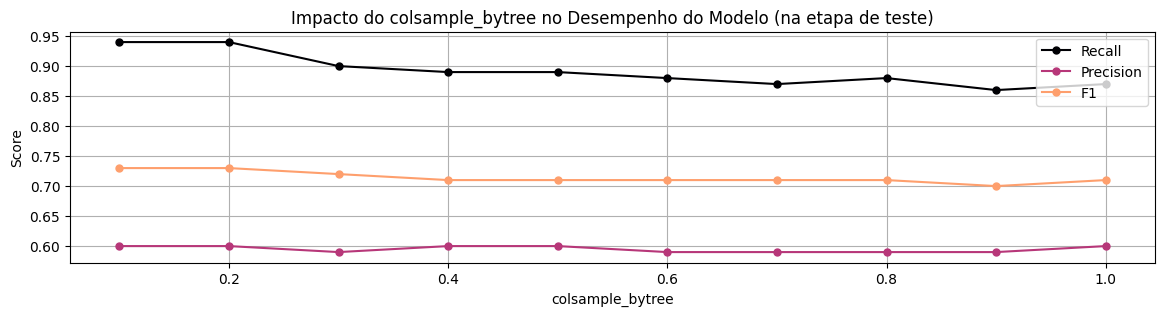

In [73]:
credit_result_df = XGBClassifier_hyperparams_test(colsample_bytree_test, 'colsample_bytree',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = XGBClassifier_hyperparams_test(colsample_bytree_test, 'colsample_bytree',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

## lambda_l1
- L1 regularization
- Lasso
- Adiciona um termo de penalidade à função de perda
- Pode zerar um termo


In [74]:
lambda_l1_test = np.arange(0.1, 1.1, 0.1)

lambda_l1_test = np.sort(np.concatenate((lambda_l1_test,
                                [1e-20, 1e-19, 1e-18, 1e-17, 1e-16, 1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 
                                 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 
                                 0.01, 0.05])))

>> Hiperparâmetro: lambda_l1
>> Modelo: LGBM


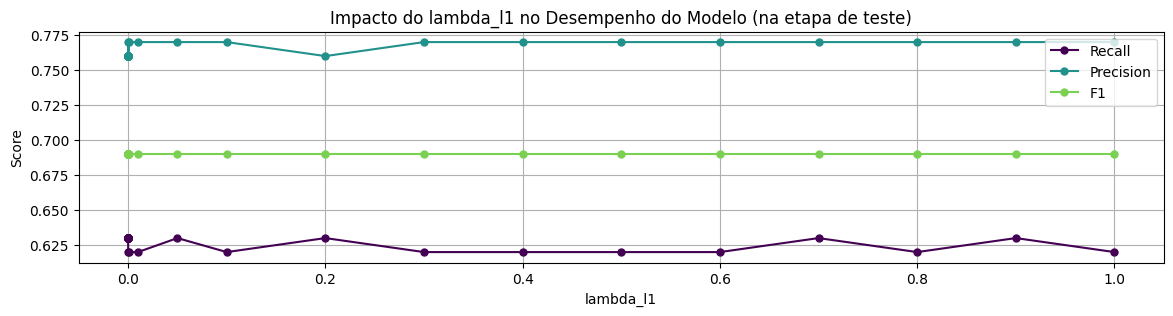

>> Hiperparâmetro: lambda_l1
>> Modelo: LGBM


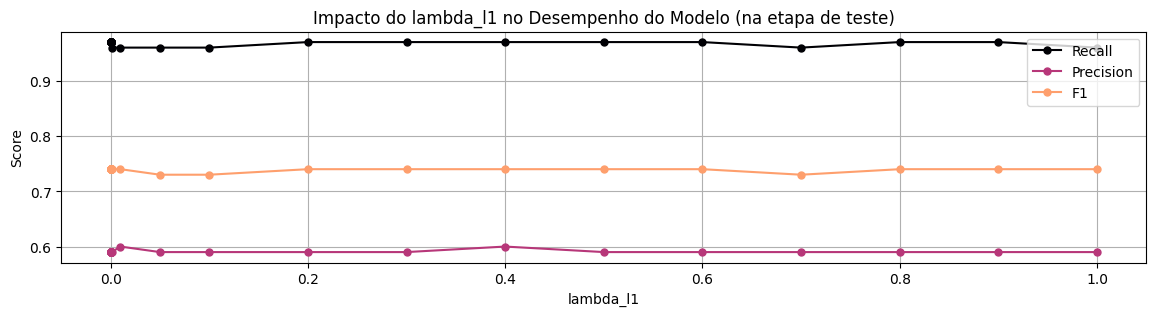

In [75]:
credit_result_df = LGBM_hyperparams_test(lambda_l1_test, 'lambda_l1',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = LGBM_hyperparams_test(lambda_l1_test, 'lambda_l1',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

## lambda_l2
- L2 regularization
- Ridge
- Adiciona um termo de penalidade à função de perda
- Nunca é zero

In [76]:
lambda_l2_test = np.arange(0.1, 1.1, 0.1)

lambda_l2_test = np.sort(np.concatenate((lambda_l2_test,
                                [1e-20, 1e-19, 1e-18, 1e-17, 1e-16, 1e-15, 1e-14, 1e-13, 1e-12, 1e-11, 
                                 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 
                                 0.01, 0.05])))

>> Hiperparâmetro: lambda_l2
>> Modelo: LGBM


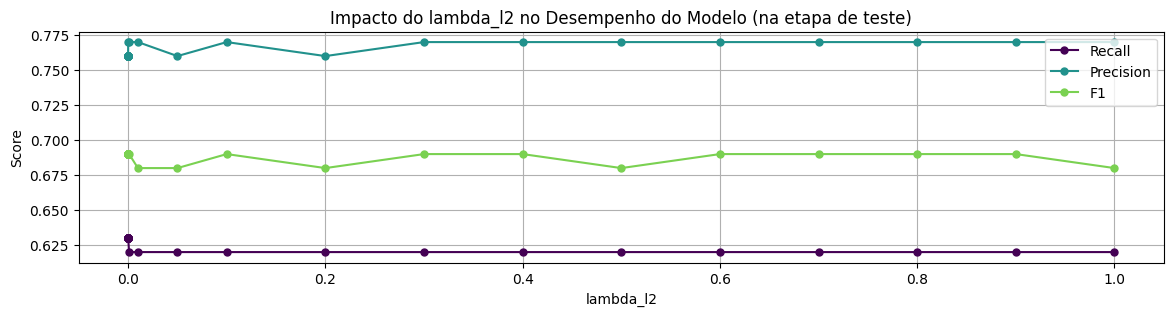

>> Hiperparâmetro: lambda_l2
>> Modelo: LGBM


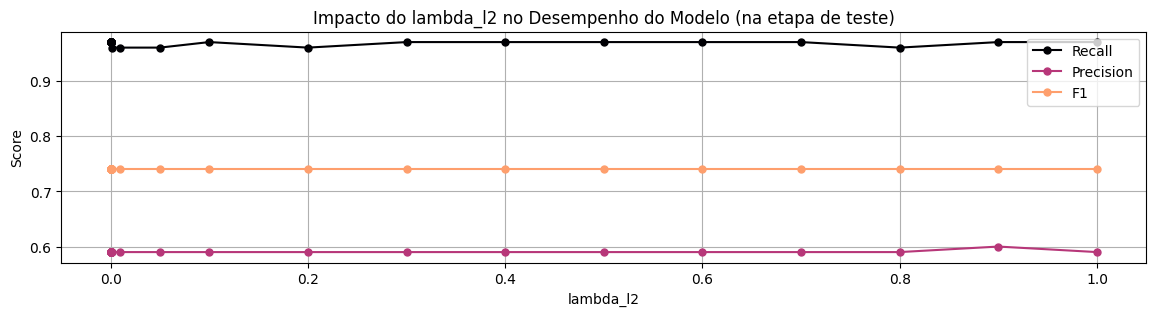

In [77]:
credit_result_df = LGBM_hyperparams_test(lambda_l2_test, 'lambda_l2',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = LGBM_hyperparams_test(lambda_l2_test, 'lambda_l2',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

>> Hiperparâmetro: lambda
>> Modelo: XGBoost


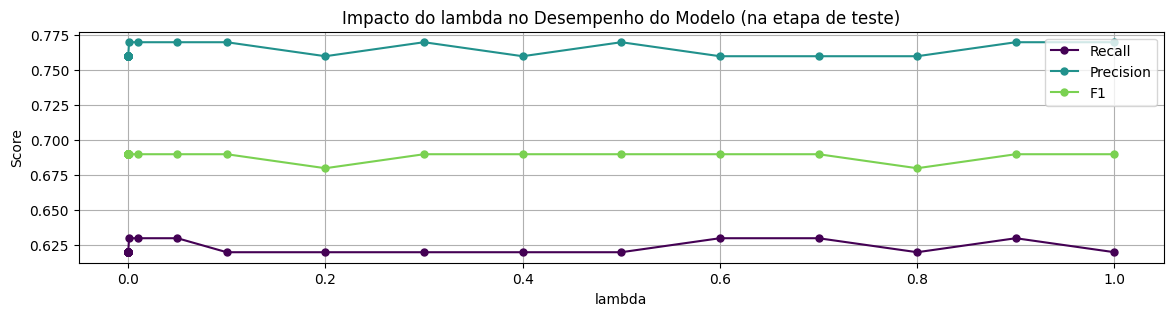

>> Hiperparâmetro: lambda
>> Modelo: XGBoost


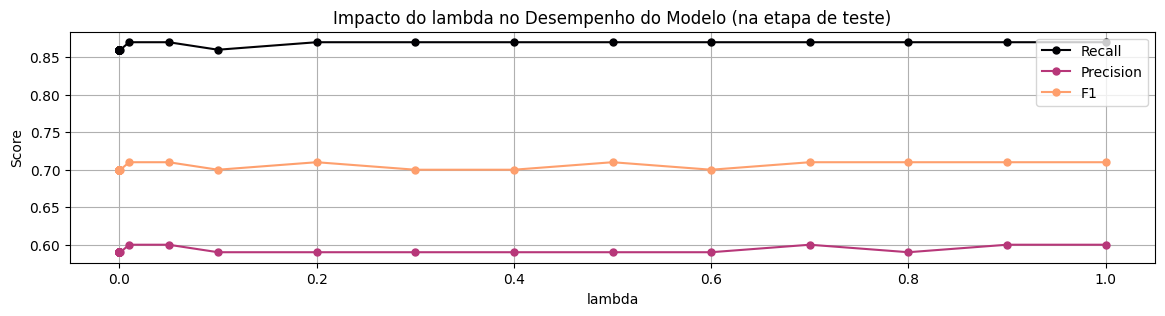

In [78]:
credit_result_df = XGBClassifier_hyperparams_test(lambda_l2_test, 'lambda',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = XGBClassifier_hyperparams_test(lambda_l2_test, 'lambda',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

## min_child_weight
- Peso mínimo total das amostras que uma folha da árvore deve ter para que a divisão continue
- Se for muito baixo, o modelo pode se ajustar excessivamente aos dados de treinamento, capturando ruído

In [79]:
# Qual é a diferença de min_child_weight para min_data_in_bin? 

# min_data_in_bin: define a quantidade mínima de dados para cada bin (divisões igualitárias) para treinar uma feature contínua. 

>> Hiperparâmetro: min_child_weight
>> Modelo: LGBM


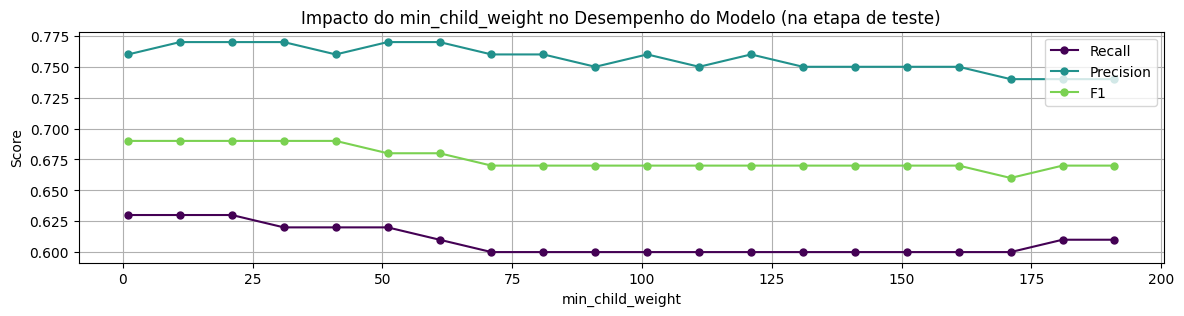

>> Hiperparâmetro: min_child_weight
>> Modelo: LGBM


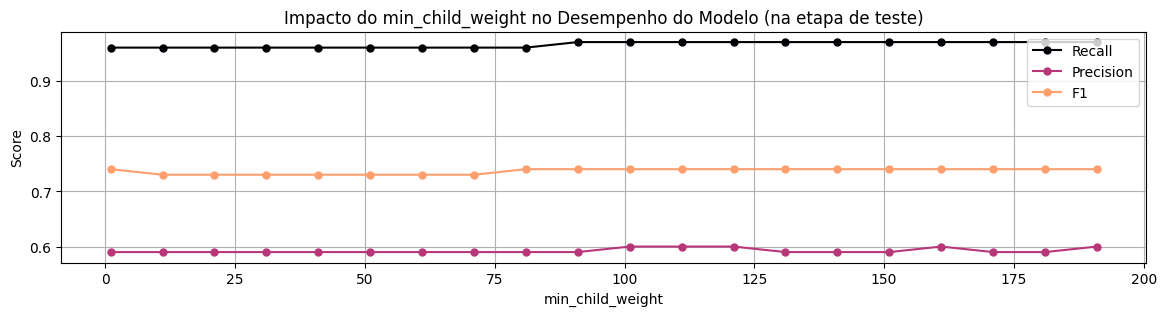

In [80]:
min_child_weight_test = np.arange(1, 201, 10)

credit_result_df = LGBM_hyperparams_test(min_child_weight_test, 'min_child_weight',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = LGBM_hyperparams_test(min_child_weight_test, 'min_child_weight',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

>> Hiperparâmetro: min_child_weight
>> Modelo: XGBoost


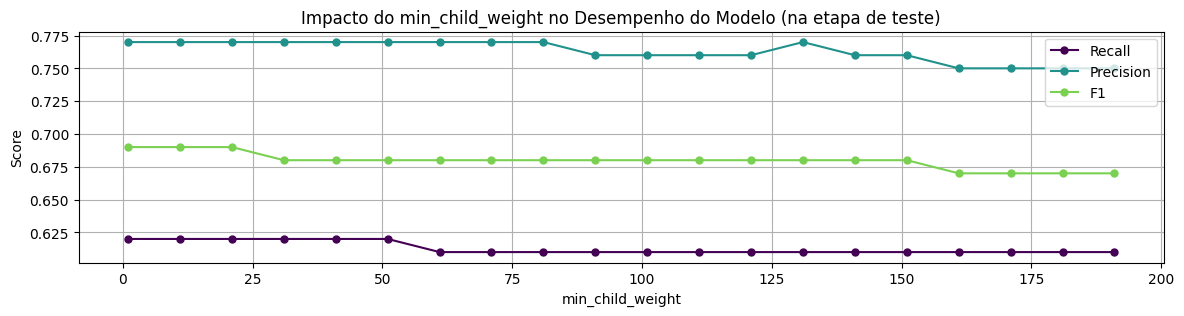

>> Hiperparâmetro: min_child_weight
>> Modelo: XGBoost


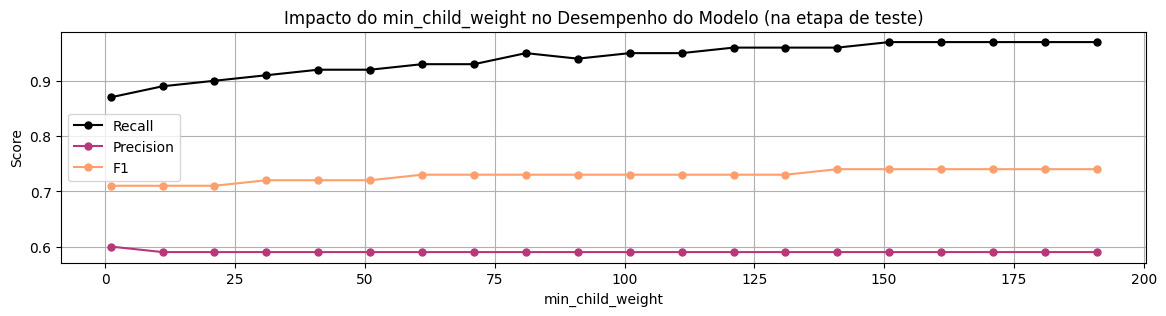

In [81]:
min_child_weight_test = np.arange(1, 201, 10)

credit_result_df = XGBClassifier_hyperparams_test(min_child_weight_test, 'min_child_weight',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = XGBClassifier_hyperparams_test(min_child_weight_test, 'min_child_weight',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

## num_leaves
- Número máximo de folhas (nós de decisão).
- Quanto maior o número de folhas, menor a quantidade de dados por folha


>> Hiperparâmetro: num_leaves
>> Modelo: LGBM


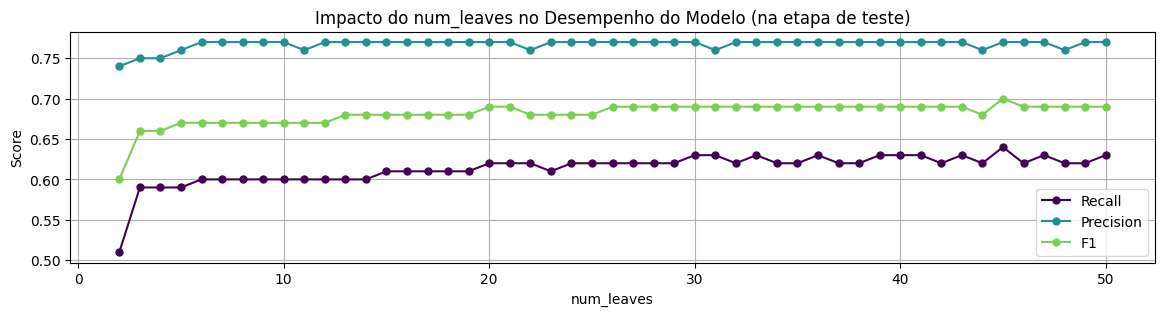

>> Hiperparâmetro: num_leaves
>> Modelo: LGBM


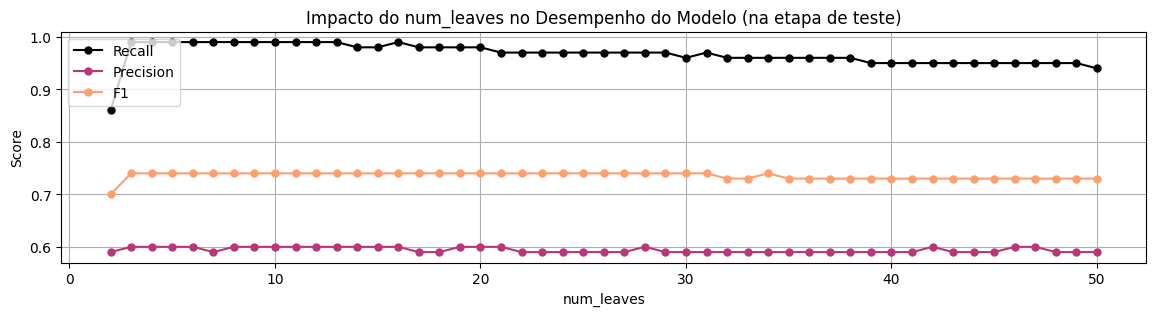

In [82]:
num_leaves_test = np.arange(2, 51, 1)

credit_result_df = LGBM_hyperparams_test(num_leaves_test, 'num_leaves',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = LGBM_hyperparams_test(num_leaves_test, 'num_leaves',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

>> Hiperparâmetro: max_leaves
>> Modelo: XGBoost


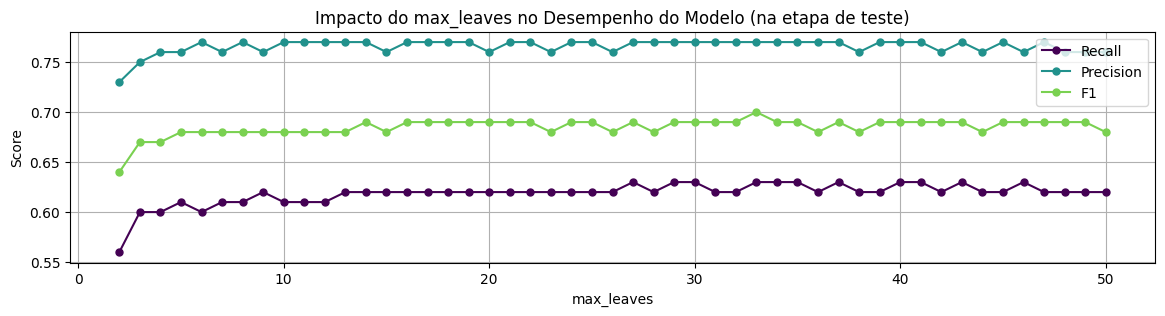

>> Hiperparâmetro: max_leaves
>> Modelo: XGBoost


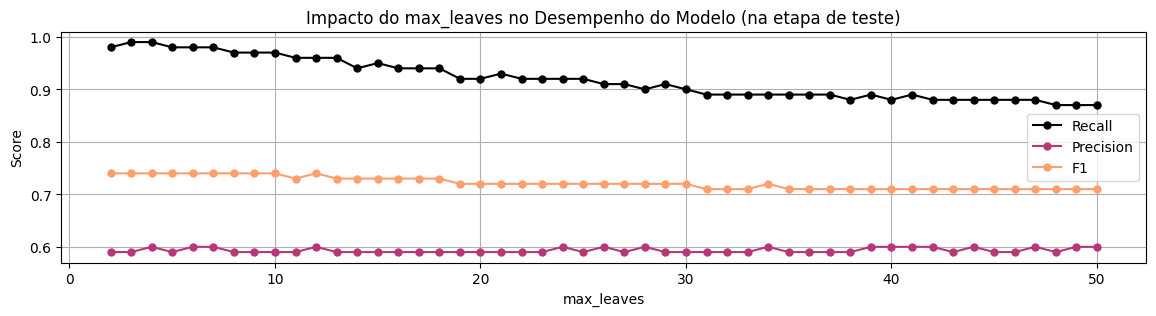

In [83]:
num_leaves_test = np.arange(2, 51, 1)

credit_result_df = XGBClassifier_hyperparams_test(num_leaves_test, 'max_leaves',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = XGBClassifier_hyperparams_test(num_leaves_test, 'max_leaves',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

## max_bin
- Define a quantidade máxima de bins (divisões igualitárias) para treinar uma feature contínua. 


>> Hiperparâmetro: max_bin
>> Modelo: LGBM


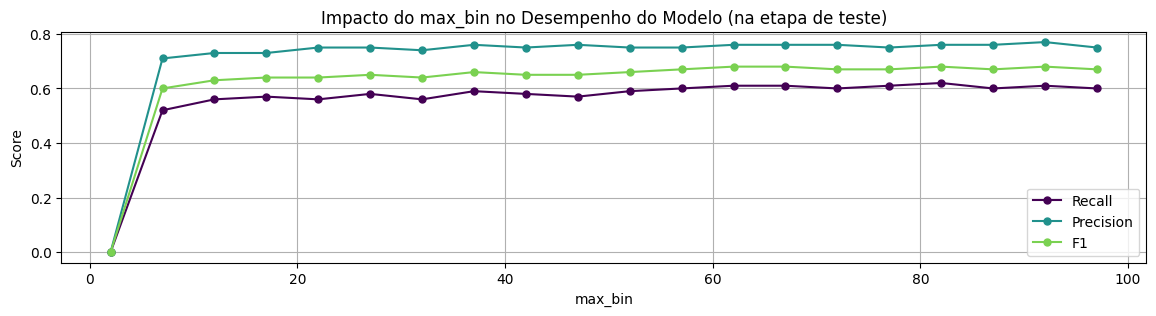

>> Hiperparâmetro: max_bin
>> Modelo: LGBM


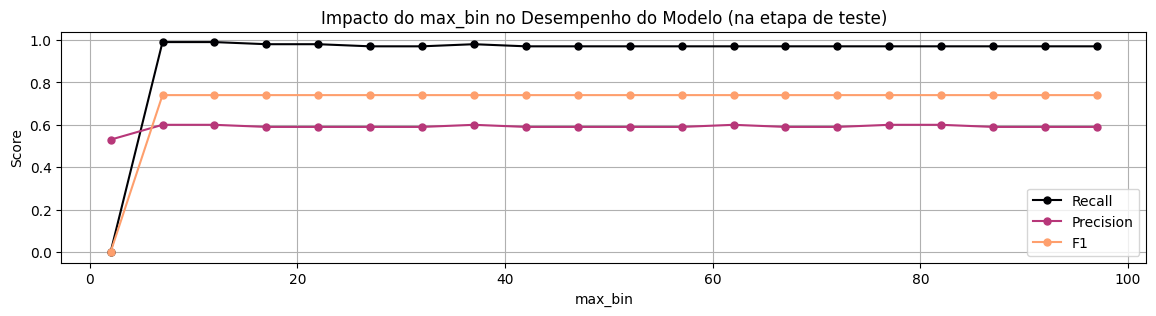

In [84]:
max_bin_test = np.arange(2, 102, 5)

credit_result_df = LGBM_hyperparams_test(max_bin_test, 'max_bin',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = LGBM_hyperparams_test(max_bin_test, 'max_bin',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

>> Hiperparâmetro: max_bin
>> Modelo: XGBoost


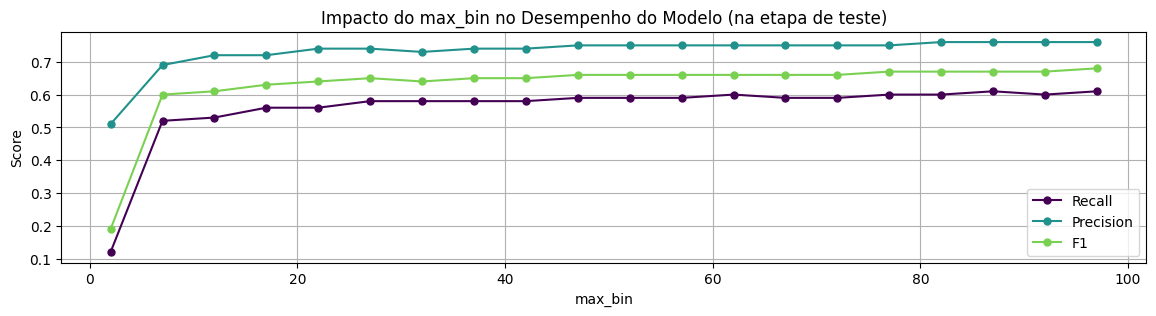

>> Hiperparâmetro: max_bin
>> Modelo: XGBoost


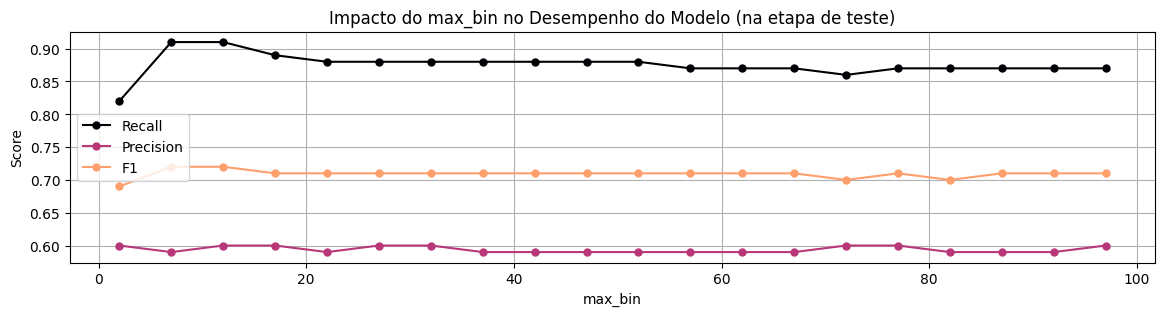

In [85]:
max_bin_test = np.arange(2, 102, 5)

credit_result_df = XGBClassifier_hyperparams_test(max_bin_test, 'max_bin',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = XGBClassifier_hyperparams_test(max_bin_test, 'max_bin',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

## min_data_in_leaf/min_child_samples
- Mínimo de registros em uma folha (nó final).
- Evita que as folhas sejam muito pequenas, evitando overfit, já que evita o ajuste de detalhes

>> Hiperparâmetro: min_data_in_leaf
>> Modelo: LGBM


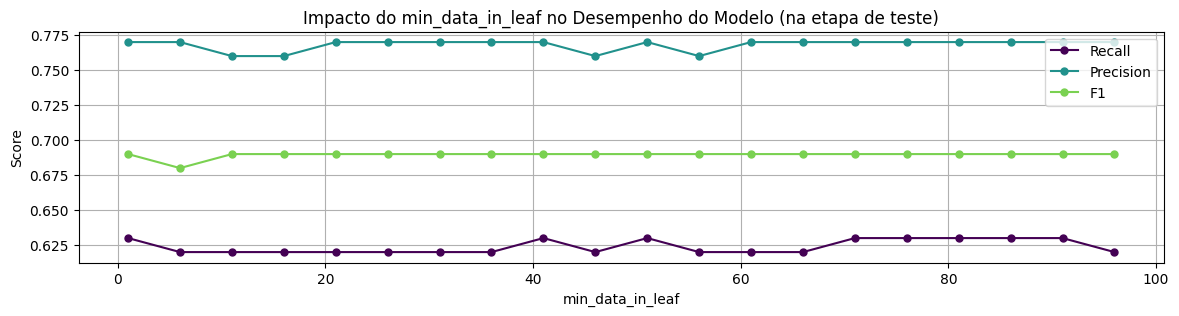

>> Hiperparâmetro: min_data_in_leaf
>> Modelo: LGBM


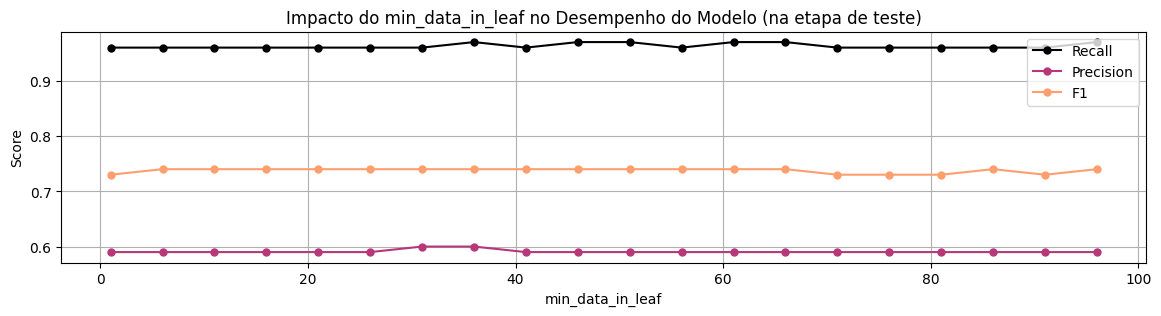

In [86]:
min_data_in_leaf_test = np.arange(1, 101, 5)

credit_result_df = LGBM_hyperparams_test(min_data_in_leaf_test, 'min_data_in_leaf',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = LGBM_hyperparams_test(min_data_in_leaf_test, 'min_data_in_leaf',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

>> Hiperparâmetro: min_data_in_leaf
>> Modelo: XGBoost


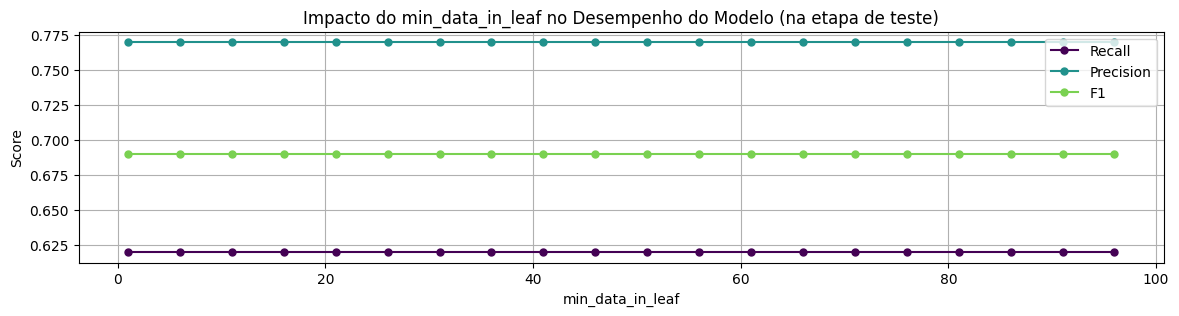

>> Hiperparâmetro: min_data_in_leaf
>> Modelo: XGBoost


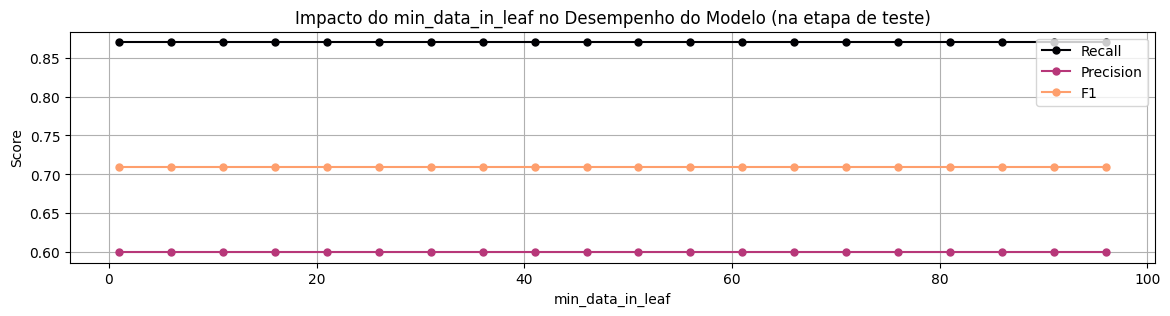

In [87]:
min_data_in_leaf_test = np.arange(1, 101, 5)

credit_result_df = XGBClassifier_hyperparams_test(min_data_in_leaf_test, 'min_data_in_leaf',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = XGBClassifier_hyperparams_test(min_data_in_leaf_test, 'min_data_in_leaf',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

## min_gain_to_split
- O ganho mínimo para realizar uma divisão
- Acelera o treinamento


>> Hiperparâmetro: min_gain_to_split
>> Modelo: LGBM


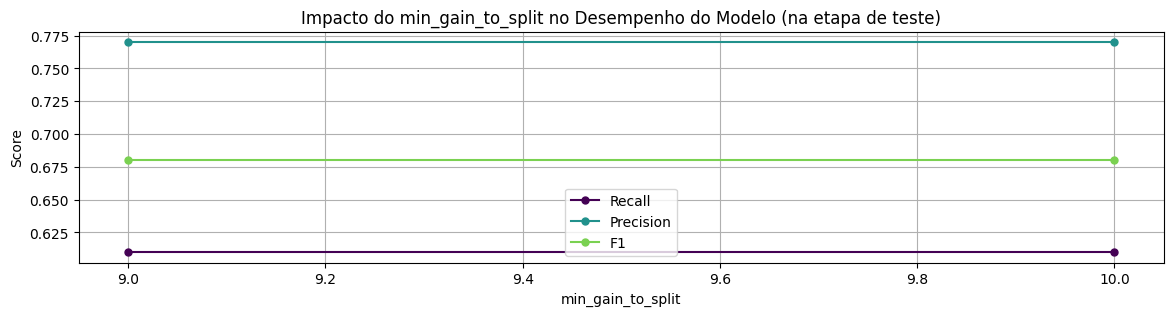

>> Hiperparâmetro: min_gain_to_split
>> Modelo: LGBM


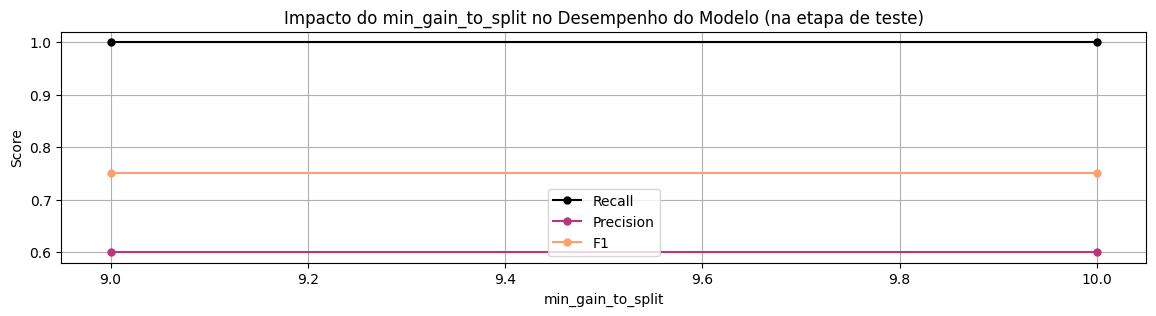

In [88]:
min_gain_to_split_test = np.arange(9, 11, 1)

credit_result_df = LGBM_hyperparams_test(min_gain_to_split_test, 'min_gain_to_split',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = LGBM_hyperparams_test(min_gain_to_split_test, 'min_gain_to_split',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

## subsample/bagging_freq/bagging_fraction
- Porcentagem de parâmetros selecionados em cada iteração (sem resampling).
- Ao usar apenas um subconjunto dos dados para cada árvore, o modelo pode se beneficiar da diversidade
- Reduzir a correlação entre as árvores

>> Hiperparâmetro: subsample
>> Modelo: LGBM


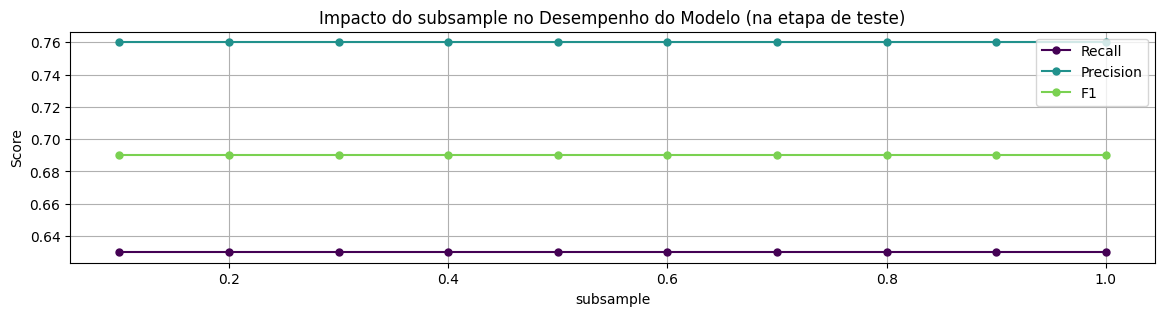

>> Hiperparâmetro: subsample
>> Modelo: LGBM


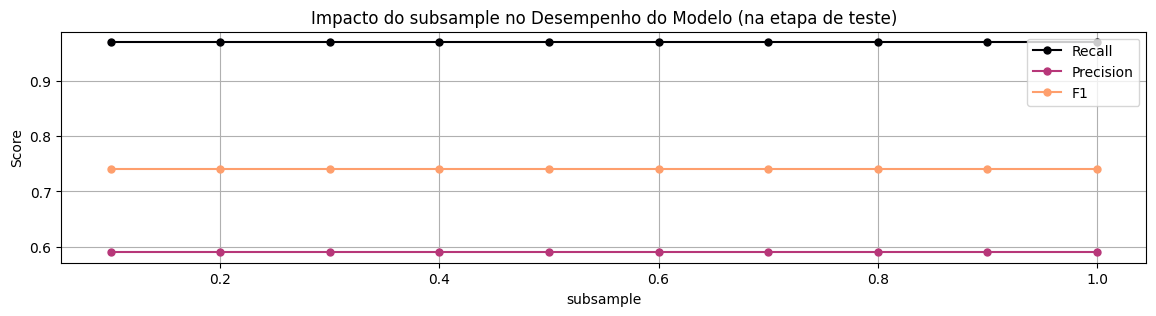

In [89]:
bagging_test = np.arange(0.1, 1.1, 0.1)

credit_result_df = LGBM_hyperparams_test(bagging_test, 'subsample',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = LGBM_hyperparams_test(bagging_test, 'subsample',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')

>> Hiperparâmetro: subsample
>> Modelo: XGBoost


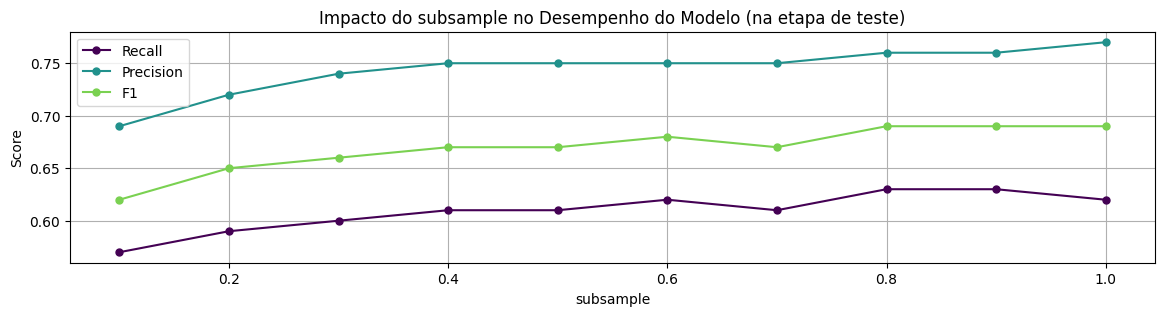

>> Hiperparâmetro: subsample
>> Modelo: XGBoost


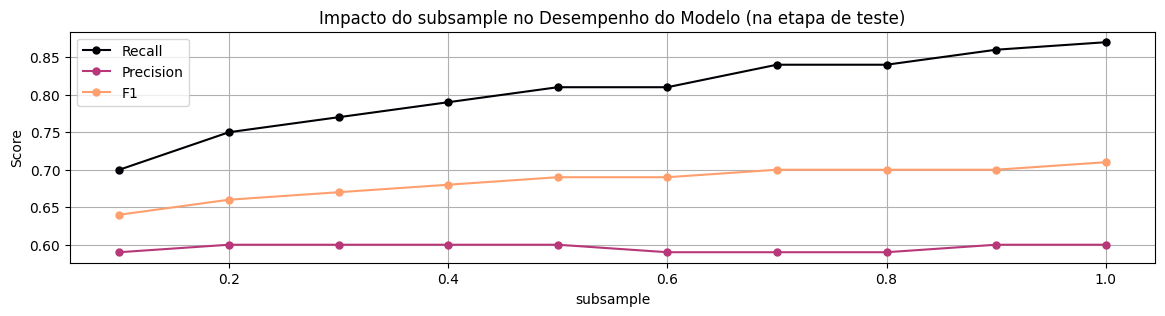

In [90]:
bagging_test = np.arange(0.1, 1.1, 0.1)

credit_result_df = XGBClassifier_hyperparams_test(bagging_test, 'subsample',
                                         X_train_credit, X_test_credit, y_train_credit, y_test_credit, 'viridis')

smoke_result_df = XGBClassifier_hyperparams_test(bagging_test, 'subsample',
                                         X_train_smoke, X_test_smoke, y_train_smoke, y_test_smoke, 'magma')